# Análise de Produtividade de Culturas

Este notebook realiza uma análise completa de dados de produtividade agrícola, incluindo:
- Análise Exploratória de Dados (EDA)
- Análise de Correlação
- Clustering com K-Means
- Identificação de Outliers
- Visualizações 2D e 3D dos Clusters
- Modelos de Regressão (aprendizado supervisionado)

O objetivo é identificar padrões e insights que possam ajudar a otimizar a produtividade agrícola.

## 1. Configuração e Importação de Bibliotecas

In [1]:
# Importação das bibliotecas necessárias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from mpl_toolkits.mplot3d import Axes3D  # Para visualização 3D de clusters
from IPython.display import display, Markdown

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Exibir todas as colunas do DataFrame
pd.set_option('display.max_columns', None)

# Diretório de imagens
IMAGES_DIR = os.path.join('..', 'images')
os.makedirs(IMAGES_DIR, exist_ok=True)

## 2. Carregamento e Exploração dos Dados

In [2]:
def load_data(file_path):
    """
    Carrega os dados do arquivo CSV e retorna um DataFrame pandas.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Dados carregados com sucesso: {file_path}")
        print(f"Dimensões do dataset: {df.shape[0]} linhas x {df.shape[1]} colunas")
        return df
    except Exception as e:
        print(f"Erro ao carregar os dados: {e}")
        return None

# Ajuste este caminho conforme a sua estrutura
file_path = os.path.join('..', 'data', 'crop_yield.csv')
df = load_data(file_path)

display(Markdown("### Primeiras linhas do dataset:"))
display(df.head())

Dados carregados com sucesso: ..\data\crop_yield.csv
Dimensões do dataset: 156 linhas x 6 colunas


### Primeiras linhas do dataset:

,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


### 2.1 Informações do Dataset

In [3]:
def display_dataset_info(df):
    """
    Exibe informações sobre o dataset (info, describe, dtypes, etc.).
    """
    display(Markdown("### Informações do Dataset:"))
    display(df.info())

    display(Markdown("### Estatísticas Descritivas:"))
    display(df.describe())

    display(Markdown("### Tipos de Dados:"))
    display(pd.DataFrame(df.dtypes, columns=['Tipo de Dado']))

    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        display(Markdown("### Valores Únicos em Colunas Categóricas:"))
        for col in categorical_cols:
            print(f"\n{col}: {df[col].nunique()} valores únicos")
            display(df[col].value_counts())

display_dataset_info(df)

### Informações do Dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Crop                                  156 non-null    object 
 1   Precipitation (mm day-1)              156 non-null    float64
 2   Specific Humidity at 2 Meters (g/kg)  156 non-null    float64
 3   Relative Humidity at 2 Meters (%)     156 non-null    float64
 4   Temperature at 2 Meters (C)           156 non-null    float64
 5   Yield                                 156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB


None

### Estatísticas Descritivas:

,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
count,156.000000,156.000000,156.000000,156.00000,156.000000
mean,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,289.457914,0.293923,0.996226,0.26105,70421.958897
min,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,2718.080000,18.400000,85.510000,26.30000,67518.750000
max,3085.790000,18.700000,86.100000,26.81000,203399.000000


### Tipos de Dados:

,Tipo de Dado
Crop,object
Precipitation (mm day-1),float64
Specific Humidity at 2 Meters (g/kg),float64
Relative Humidity at 2 Meters (%),float64
Temperature at 2 Meters (C),float64
Yield,int64


### Valores Únicos em Colunas Categóricas:


Crop: 4 valores únicos


Crop
Cocoa, beans       39
Oil palm fruit     39
Rice, paddy        39
Rubber, natural    39
Name: count, dtype: int64

### 2.2 Análise de Valores Ausentes

### Análise de Valores Ausentes:

,Valores Ausentes,Percentual (%)
Crop,0,0.0
Precipitation (mm day-1),0,0.0
Specific Humidity at 2 Meters (g/kg),0,0.0
Relative Humidity at 2 Meters (%),0,0.0
Temperature at 2 Meters (C),0,0.0
Yield,0,0.0


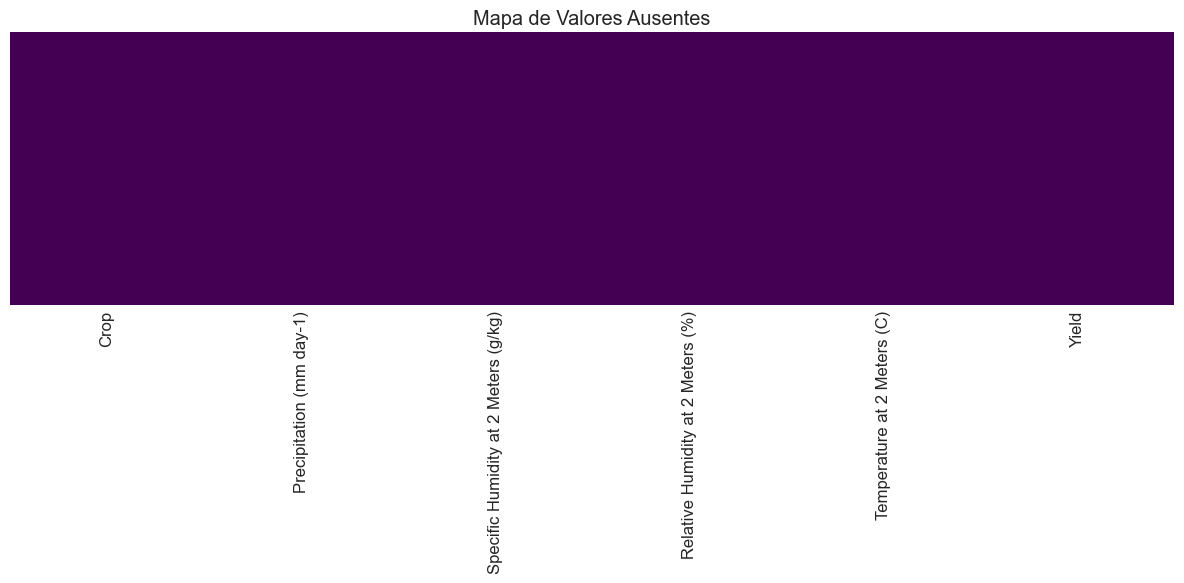

In [4]:
def analyze_missing_values(df):
    """
    Analisa valores ausentes no DataFrame.
    """
    display(Markdown("### Análise de Valores Ausentes:"))
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Valores Ausentes': missing_values,
        'Percentual (%)': missing_percent
    })
    display(missing_df)

    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Mapa de Valores Ausentes')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR, 'missing_values_heatmap.png'))
    plt.show()

    if missing_values.sum() > 0:
        display(Markdown("### Estratégias de Tratamento de Valores Ausentes:"))
        for col in df.columns[missing_values>0]:
            print(f"\nColuna: {col} - {missing_percent[col]:.2f}% ausentes")
            if missing_percent[col]<5:
                print("  Recomendação: Remover linhas ou imputar média/mediana")
            elif missing_percent[col]<30:
                print("  Recomendação: Imputar usando técnicas mais avançadas")
            else:
                print("  Recomendação: Considerar remover a coluna ou investigar causa.")

analyze_missing_values(df)

### 2.3 Tratamento de Valores Ausentes (se necessário)

In [5]:
def handle_missing_values(df):
    """
    Trata valores ausentes no DataFrame (mediana para numéricos, moda para categóricos).
    """
    if df.isnull().sum().sum()==0:
        print("Não há valores ausentes para tratar.")
        return df
    
    df_clean = df.copy()
    for col in df.columns[df.isnull().sum()>0]:
        if df[col].dtype in ['int64','float64']:
            med = df[col].median()
            df_clean[col].fillna(med, inplace=True)
            print(f"Valores ausentes em '{col}' preenchidos c/ mediana: {med}")
        else:
            modev = df[col].mode()[0]
            df_clean[col].fillna(modev, inplace=True)
            print(f"Valores ausentes em '{col}' preenchidos c/ modo: {modev}")
    
    if df_clean.isnull().sum().sum()==0:
        print("\nTodos os valores ausentes foram tratados!")
    else:
        print("Ainda existem valores ausentes.")
    return df_clean

df_clean = handle_missing_values(df)
print(f"\nValores ausentes restantes: {df_clean.isnull().sum().sum()}")

Não há valores ausentes para tratar.

Valores ausentes restantes: 0


## 3. Análise Exploratória de Dados (EDA)

### 3.1 Análise da Distribuição dos Dados

### Distribuição das Variáveis Numéricas:

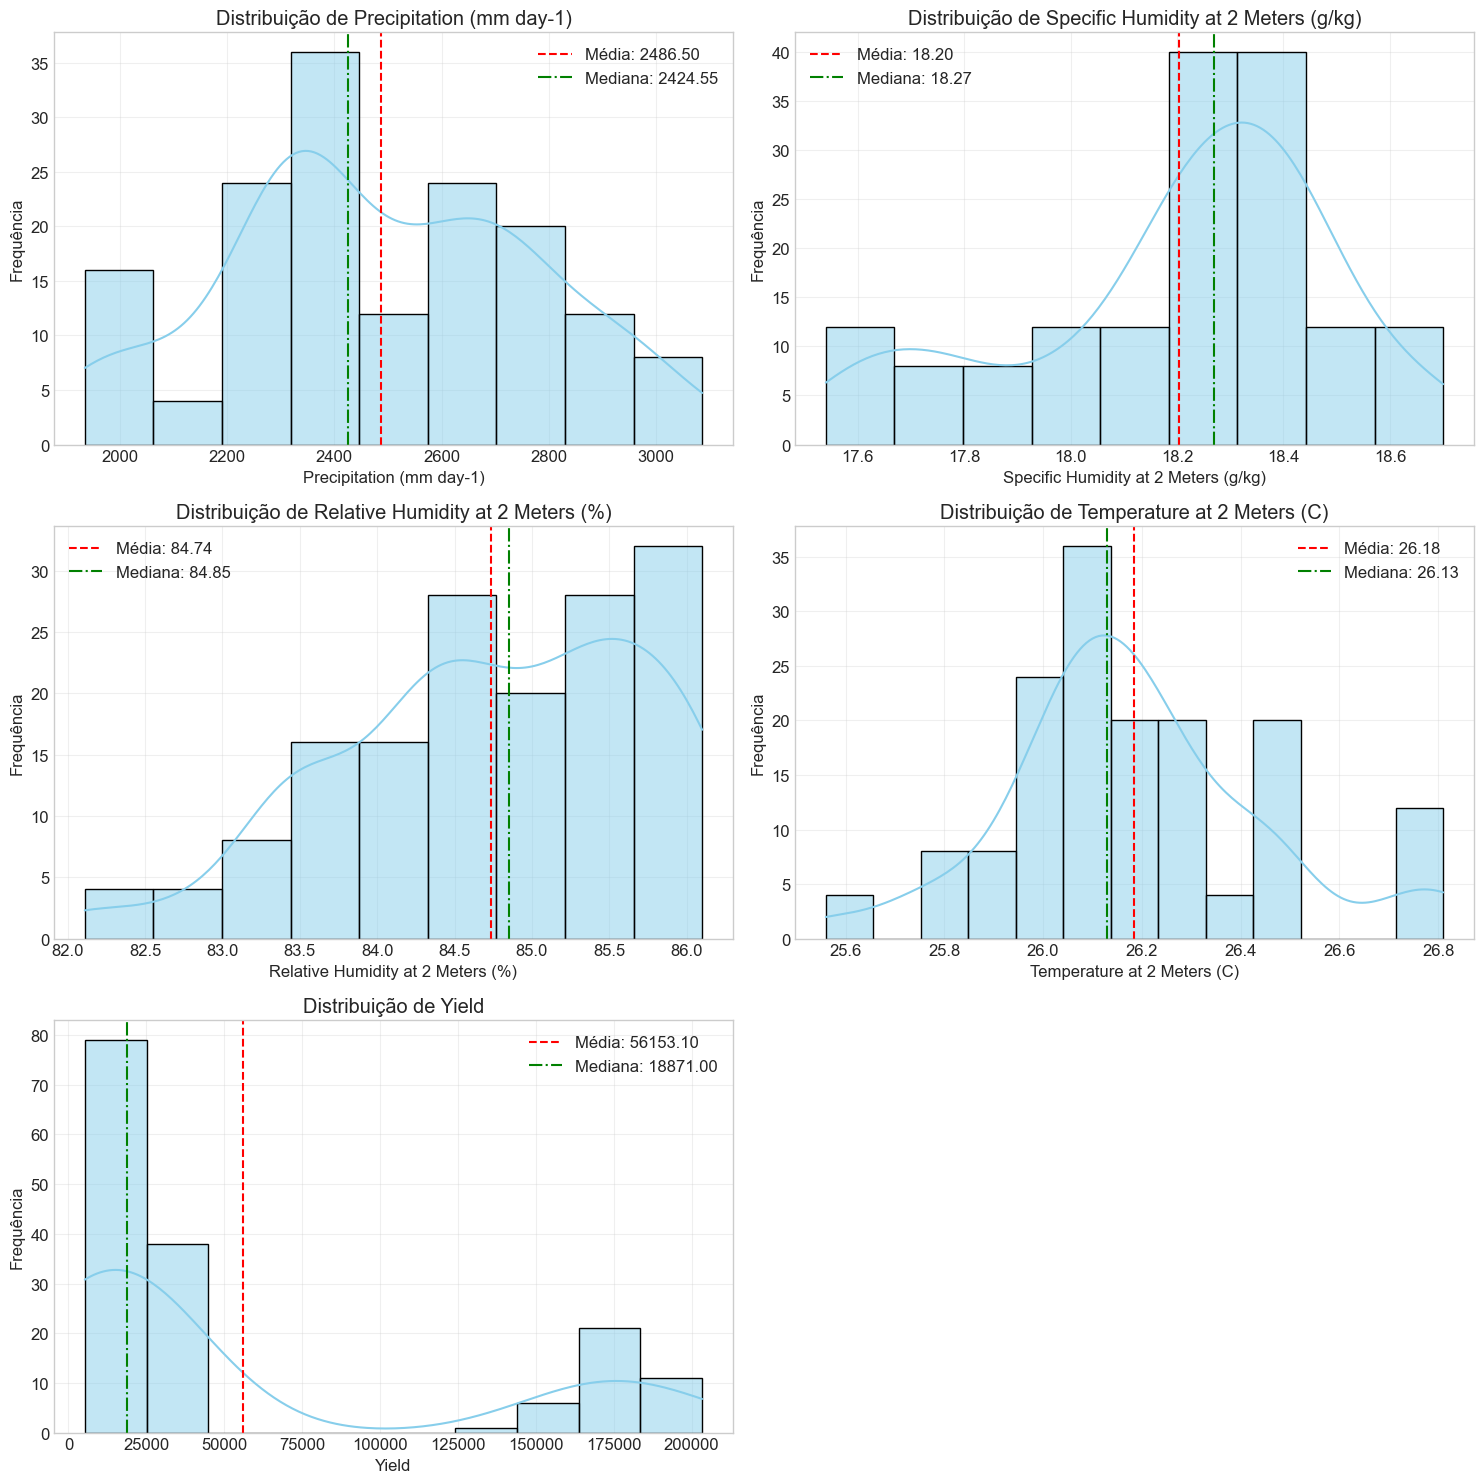

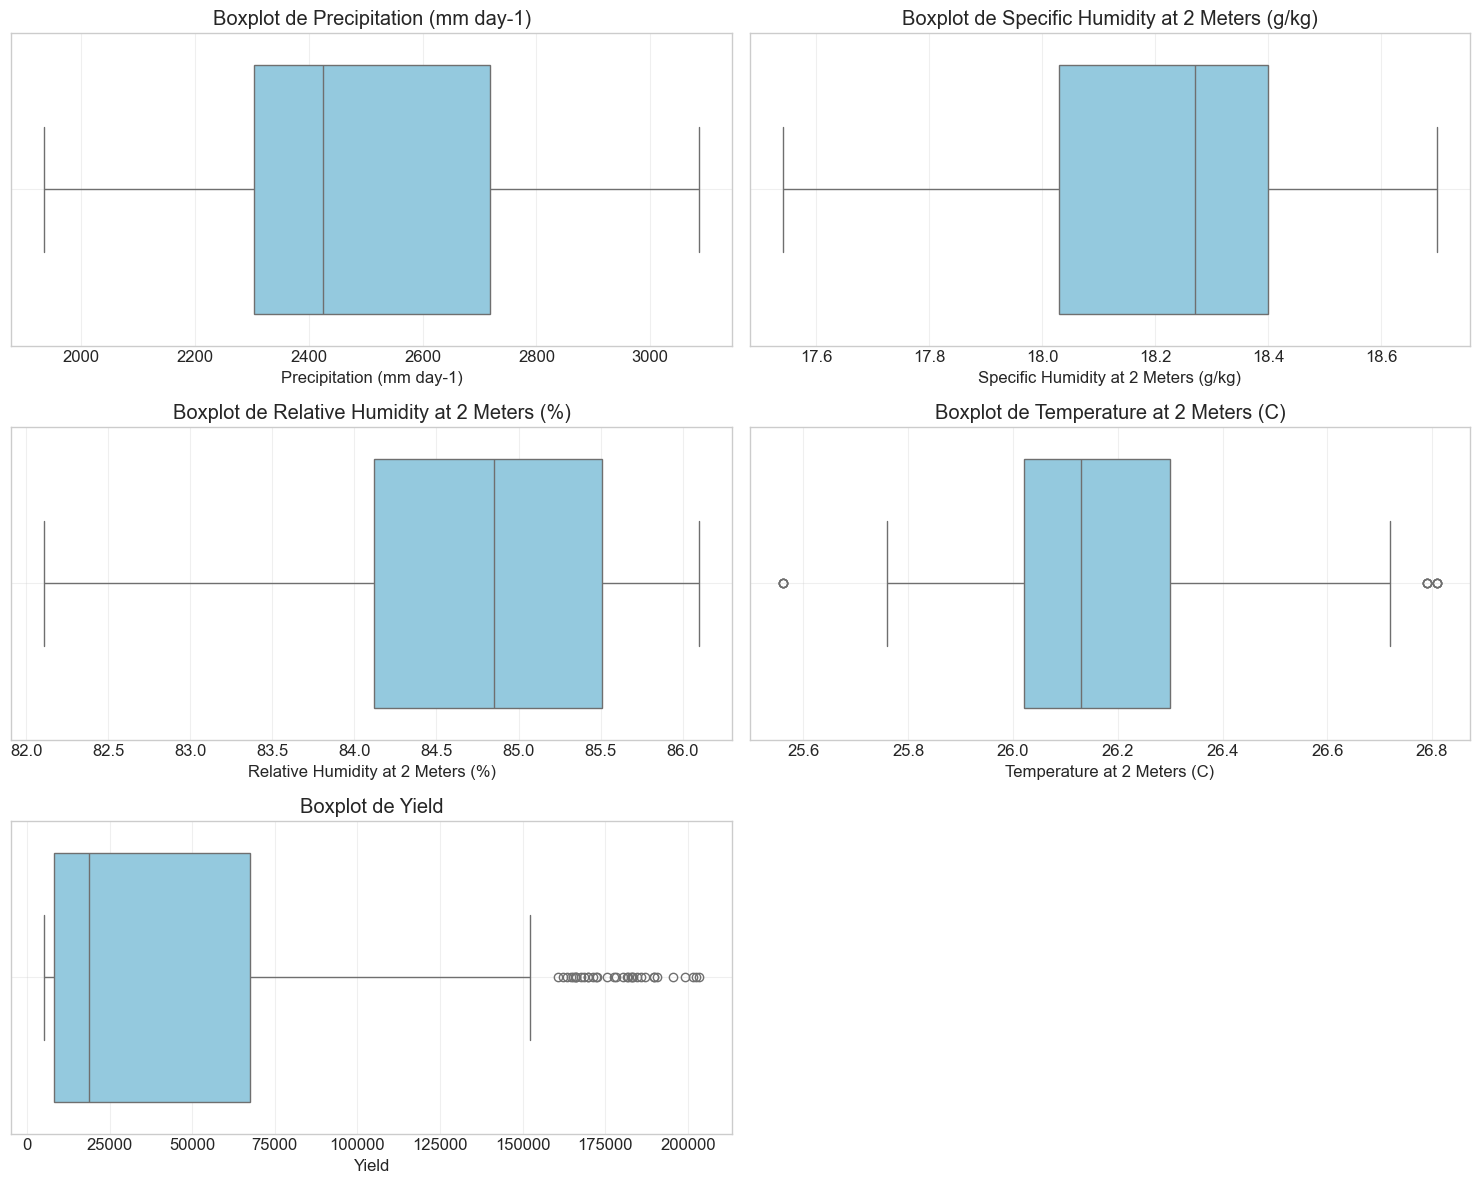

### Distribuição das Variáveis Categóricas:

C:\Users\jcorr\AppData\Local\Temp\ipykernel_57292\2506022951.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vcounts.index, y=vcounts.values, palette='viridis')


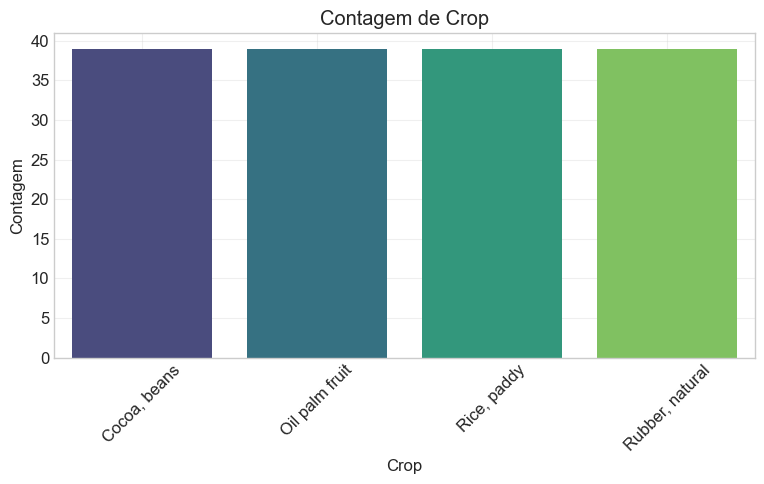

In [6]:
def analyze_data_distribution(df):
    display(Markdown("### Distribuição das Variáveis Numéricas:"))
    numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    n_cols=2
    n_rows=(len(numeric_cols)+n_cols-1)//n_cols

    # Histograma
    plt.figure(figsize=(15,n_rows*5))
    for i,col in enumerate(numeric_cols):
        plt.subplot(n_rows,n_cols,i+1)
        sns.histplot(df[col], kde=True, color='skyblue')
        mean_v=df[col].mean()
        med_v=df[col].median()
        plt.axvline(mean_v, color='red', linestyle='--', label=f'Média: {mean_v:.2f}')
        plt.axvline(med_v, color='green', linestyle='-.', label=f'Mediana: {med_v:.2f}')
        plt.title(f'Distribuição de {col}')
        plt.xlabel(col)
        plt.ylabel('Frequência')
        plt.legend()
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR,'numeric_distributions.png'))
    plt.show()

    # Boxplot
    plt.figure(figsize=(15,n_rows*4))
    for i,col in enumerate(numeric_cols):
        plt.subplot(n_rows,n_cols,i+1)
        sns.boxplot(x=df[col], color='skyblue')
        plt.title(f'Boxplot de {col}')
        plt.xlabel(col)
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR,'numeric_boxplots.png'))
    plt.show()

    # Categóricas
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    if len(categorical_cols)>0:
        display(Markdown("### Distribuição das Variáveis Categóricas:"))
        n_rows_cat=(len(categorical_cols)+n_cols-1)//n_cols
        plt.figure(figsize=(15,n_rows_cat*5))
        for i,col in enumerate(categorical_cols):
            plt.subplot(n_rows_cat,n_cols,i+1)
            vcounts=df[col].value_counts().sort_values(ascending=False)
            sns.barplot(x=vcounts.index, y=vcounts.values, palette='viridis')
            plt.title(f'Contagem de {col}')
            plt.xlabel(col)
            plt.ylabel('Contagem')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_DIR,'categorical_distributions.png'))
        plt.show()

analyze_data_distribution(df_clean)

### 3.2 Análise de Correlação

### Matriz de Correlação:

,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
Precipitation (mm day-1),1.000000,0.488483,0.749464,-0.083927,0.018830
Specific Humidity at 2 Meters (g/kg),0.488483,1.000000,0.436687,0.699230,0.012651
Relative Humidity at 2 Meters (%),0.749464,0.436687,1.000000,-0.337313,0.000008
Temperature at 2 Meters (C),-0.083927,0.699230,-0.337313,1.000000,0.013007
Yield,0.018830,0.012651,0.000008,0.013007,1.000000


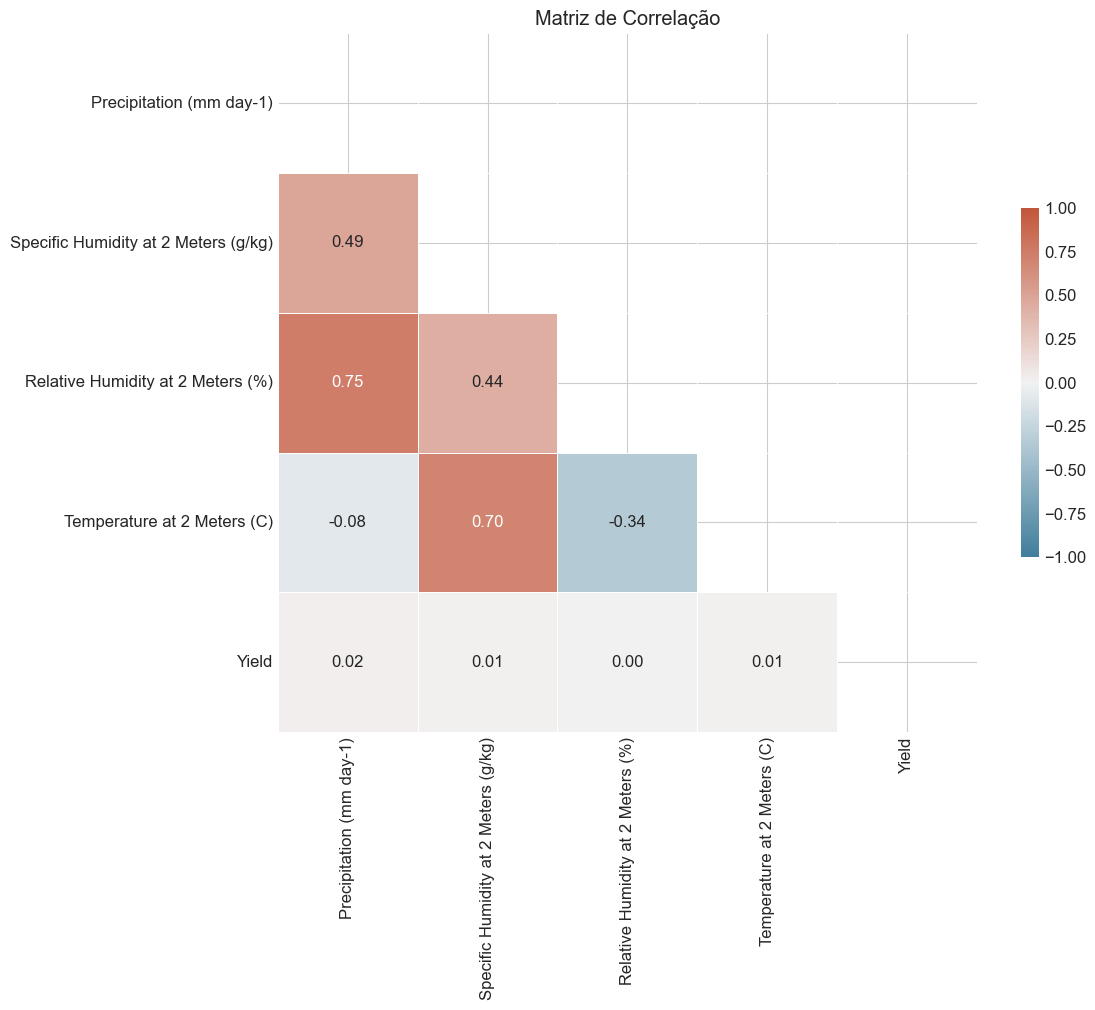

### Correlações Significativas:

,Variável 1,Variável 2,Correlação
2,Precipitation (mm day-1),Relative Humidity at 2 Meters (%),0.749464
8,Specific Humidity at 2 Meters (g/kg),Temperature at 2 Meters (C),0.699230


### Visualização de Pares com Correlações Significativas:

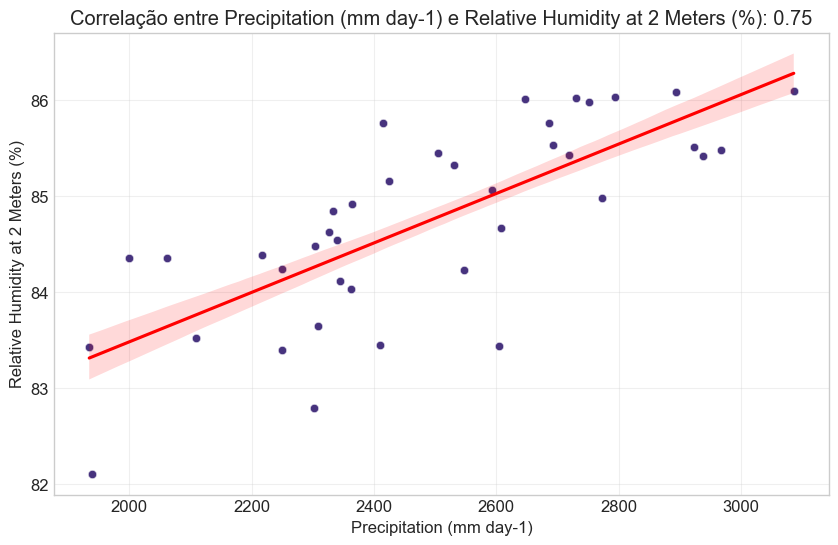

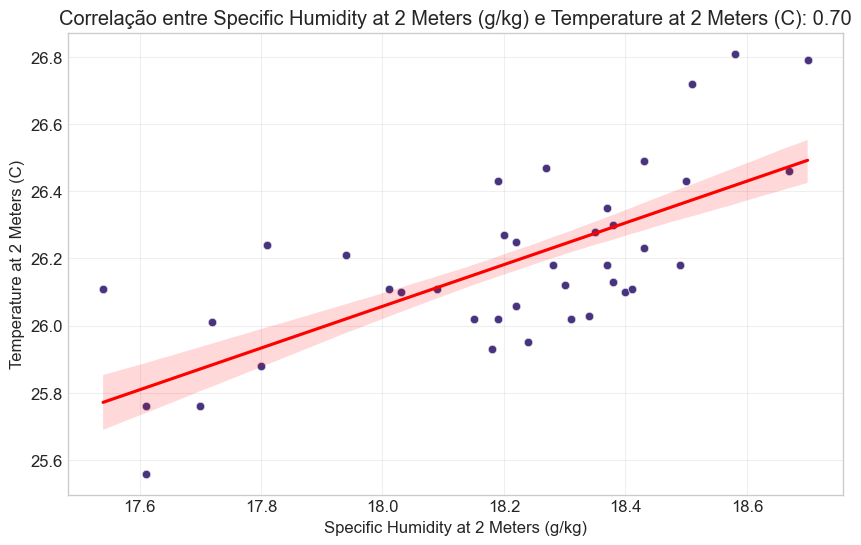

In [7]:
def sanitize_filename(name: str) -> str:
    """
    Remove ou substitui caracteres problemáticos em nomes de arquivo,
    como espaços, parênteses, barras, etc.
    """
    return (name.replace(" ", "_")
                .replace("(", "")
                .replace(")", "")
                .replace("/", "_")
                .replace("\\", "_")
                .replace("%", "")
                .replace("°", "")
                .replace("º", "")
                .replace(",", "")
                .replace(":", "")
                .replace(";", "")
                .replace("__", "_"))

def analyze_correlations(df):
    display(Markdown("### Matriz de Correlação:"))
    numeric_df = df.select_dtypes(include=['int64','float64'])
    corr_matrix = numeric_df.corr()
    display(corr_matrix)

    plt.figure(figsize=(12,10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr_matrix,
                mask=mask,
                cmap=cmap,
                vmax=1,
                vmin=-1,
                center=0,
                square=True,
                linewidths=.5,
                annot=True,
                fmt='.2f',
                cbar_kws={"shrink": .5})
    plt.title('Matriz de Correlação')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR, 'correlation_matrix.png'))
    plt.show()

    display(Markdown("### Correlações Significativas:"))
    corr_pairs = corr_matrix.unstack().reset_index()
    corr_pairs.columns = ['Variável 1', 'Variável 2', 'Correlação']
    corr_pairs = corr_pairs[corr_pairs['Variável 1'] != corr_pairs['Variável 2']]
    corr_pairs = corr_pairs.drop_duplicates(['Correlação'])
    corr_pairs['Abs'] = corr_pairs['Correlação'].abs()
    corr_pairs = corr_pairs.sort_values('Abs', ascending=False).drop('Abs', axis=1)

    signif = corr_pairs[corr_pairs['Correlação'].abs() > 0.5]
    if len(signif) > 0:
        display(signif)
        display(Markdown("### Visualização de Pares com Correlações Significativas:"))
        top_pairs = signif.head(5)
        for _, row in top_pairs.iterrows():
            var1, var2, corr_v = row['Variável 1'], row['Variável 2'], row['Correlação']

            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=df[var1], y=df[var2], alpha=0.7)
            sns.regplot(x=df[var1], y=df[var2], scatter=False, color='red')

            plt.title(f'Correlação entre {var1} e {var2}: {corr_v:.2f}')
            plt.xlabel(var1)
            plt.ylabel(var2)
            plt.grid(True, alpha=0.3)

            # Sanitizar os nomes para o arquivo
            safe_var1 = sanitize_filename(var1)
            safe_var2 = sanitize_filename(var2)
            filename = f'correlation_{safe_var1}_{safe_var2}.png'

            plt.savefig(os.path.join(IMAGES_DIR, filename))
            plt.show()
    else:
        print("Não foram encontradas correlações (|r|>0.5).")

# Exemplo de uso (ajuste seu df_clean e IMAGES_DIR conforme necessário):
analyze_correlations(df_clean)

### 3.3 Visualização de Pares de Variáveis

<Figure size 1500x1500 with 0 Axes>

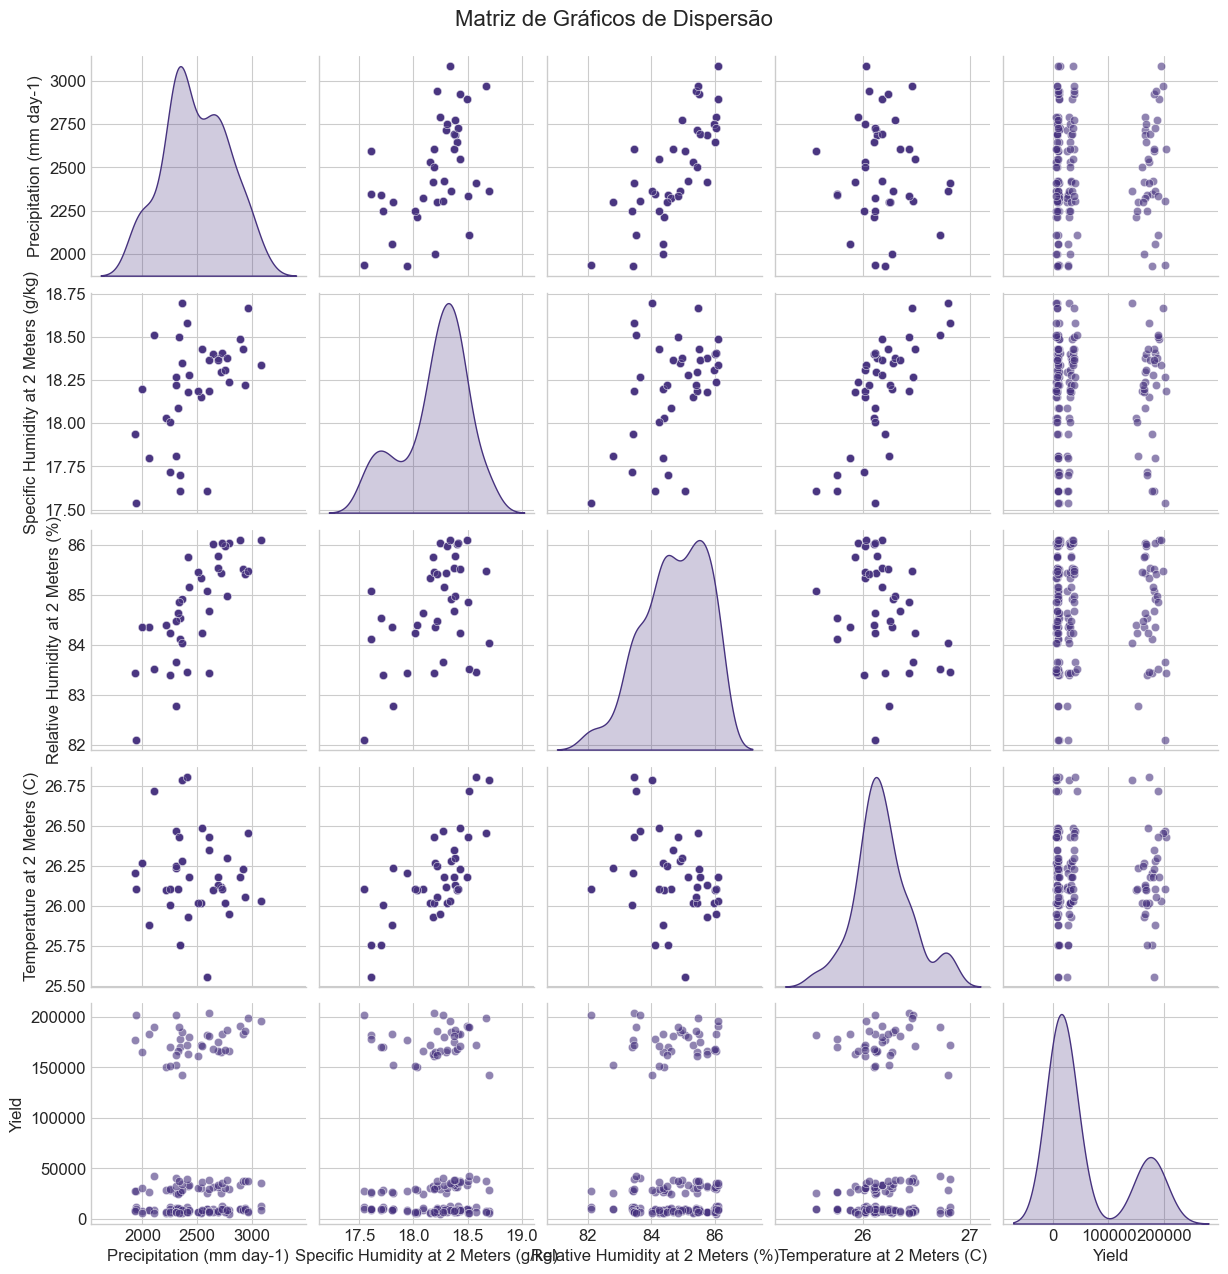

In [8]:
numeric_cols = df_clean.select_dtypes(include=['int64','float64']).columns.tolist()
if len(numeric_cols)>5:
    selected_cols = numeric_cols[:5]
    print(f"Selecionando {len(selected_cols)} colunas p/ pairplot: {selected_cols}")
else:
    selected_cols = numeric_cols

plt.figure(figsize=(15,15))
sns.pairplot(df_clean[selected_cols], diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle('Matriz de Gráficos de Dispersão', y=1.02, fontsize=16)
plt.savefig(os.path.join(IMAGES_DIR,'pairplot.png'))
plt.show()

## 4. Análise de Clustering

### 4.1 Pré-processamento de Dados para Clustering

In [9]:
def preprocess_data_for_clustering(df):
    print("\n"+"="*50)
    print("PRÉ-PROCESSAMENTO DE DADOS PARA CLUSTERING")
    print("="*50)
    cluster_df=df.copy()
    numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    # Evitar 'yield' se existir
    feature_names=[c for c in numeric_cols if c.lower()!='yield']
    print(f"Features p/ clustering: {feature_names}")
    scaler=StandardScaler()
    scaled_features=scaler.fit_transform(cluster_df[feature_names])
    print(f"Dados escalados. Shape={scaled_features.shape}")
    return cluster_df, scaled_features, feature_names, scaler

cluster_df, scaled_features, feature_names, scaler = preprocess_data_for_clustering(df_clean)


PRÉ-PROCESSAMENTO DE DADOS PARA CLUSTERING
Features p/ clustering: ['Precipitation (mm day-1)', 'Specific Humidity at 2 Meters (g/kg)', 'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)']
Dados escalados. Shape=(156, 4)


### 4.2 Determinação do Número Ótimo de Clusters


DETERMINAÇÃO DO NÚMERO ÓTIMO DE CLUSTERS
k=2: Inércia=380.05, Silhueta=0.3924


d:\FIAP\Repositorios\farm-tech-solutions-v5\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\FIAP\Repositorios\farm-tech-solutions-v5\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\jcorr\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jcorr\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, 

k=3: Inércia=227.19, Silhueta=0.4353
k=4: Inércia=183.46, Silhueta=0.4397
k=5: Inércia=144.93, Silhueta=0.4249
k=6: Inércia=116.38, Silhueta=0.4457
k=7: Inércia=99.15, Silhueta=0.4283
k=8: Inércia=87.79, Silhueta=0.4339
k=9: Inércia=79.01, Silhueta=0.4123
k=10: Inércia=69.54, Silhueta=0.4384


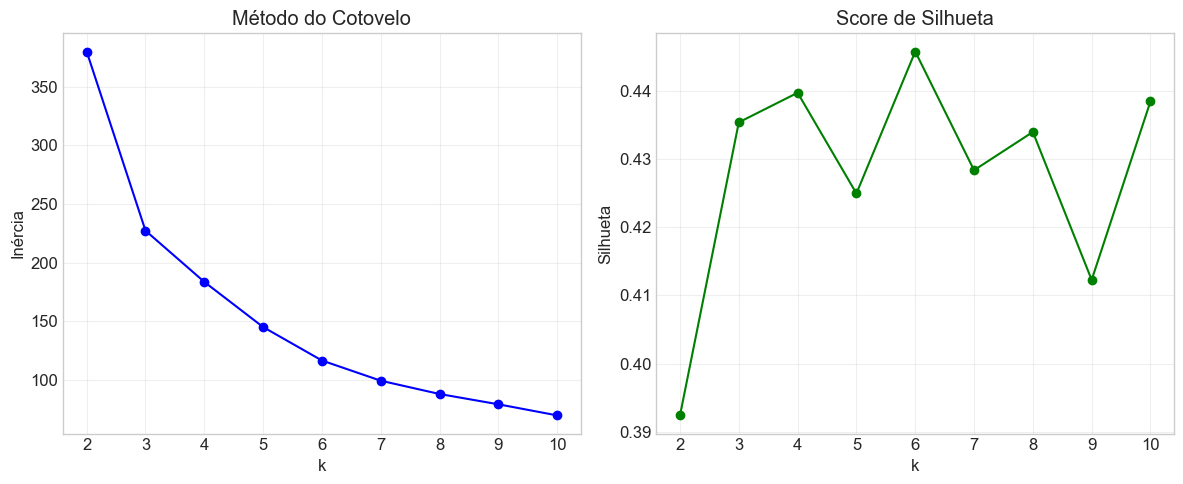


Número ótimo de clusters=6


In [10]:
def determine_optimal_clusters(scaled_features, max_clusters=10):
    print("\n"+"="*50)
    print("DETERMINAÇÃO DO NÚMERO ÓTIMO DE CLUSTERS")
    print("="*50)
    inertia=[]
    sil_scores=[]
    k_values=range(2,max_clusters+1)
    for k in k_values:
        kmeans=KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(scaled_features)
        inertia.append(kmeans.inertia_)
        labels=kmeans.labels_
        sil=silhouette_score(scaled_features, labels)
        sil_scores.append(sil)
        print(f"k={k}: Inércia={kmeans.inertia_:.2f}, Silhueta={sil:.4f}")

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(k_values, inertia, 'o-', color='blue')
    plt.xlabel('k')
    plt.ylabel('Inércia')
    plt.title('Método do Cotovelo')
    plt.grid(alpha=0.3)

    plt.subplot(1,2,2)
    plt.plot(k_values, sil_scores, 'o-', color='green')
    plt.xlabel('k')
    plt.ylabel('Silhueta')
    plt.title('Score de Silhueta')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR,'optimal_clusters.png'))
    plt.show()

    best_k = k_values[sil_scores.index(max(sil_scores))]
    print(f"\nNúmero ótimo de clusters={best_k}")
    return best_k

optimal_k = determine_optimal_clusters(scaled_features)

### 4.3 Implementação do Algoritmo K-Means

In [11]:
def perform_kmeans_clustering(cluster_df, scaled_features, n_clusters, feature_names):
    print("\n"+"="*50)
    print(f"CLUSTERING COM K-MEANS (k={n_clusters})")
    print("="*50)
    kmeans=KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels=kmeans.fit_predict(scaled_features)
    cdf=cluster_df.copy()
    cdf['Cluster']=labels
    counts=cdf['Cluster'].value_counts().sort_index()
    for cl,ct in counts.items():
        print(f"Cluster {cl}: {ct} amostras ({(ct/len(cdf))*100:.1f}%)")
    centers=kmeans.cluster_centers_
    centers_df=pd.DataFrame(centers, columns=feature_names)
    centers_df.index.name='Cluster'
    print("\nCentros dos Clusters (escalados):")
    display(centers_df)
    return cdf, centers_df

cluster_df, centers_df = perform_kmeans_clustering(cluster_df, scaled_features, optimal_k, feature_names)


CLUSTERING COM K-MEANS (k=6)
Cluster 0: 12 amostras (7.7%)
Cluster 1: 40 amostras (25.6%)
Cluster 2: 16 amostras (10.3%)
Cluster 3: 52 amostras (33.3%)
Cluster 4: 20 amostras (12.8%)
Cluster 5: 16 amostras (10.3%)

Centros dos Clusters (escalados):


,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C)
Cluster,,,,
0,-0.666863,1.343406,-1.078545,2.266398
1,-0.530599,-0.112899,0.135251,-0.217476
2,-1.319189,-1.537915,-1.817866,-0.157909
3,1.138485,0.603876,0.991528,-0.152736
4,-0.021935,0.508306,-0.573692,0.962332
5,-0.526825,-1.785374,-0.216703,-1.704726


### 4.4 Visualização dos Clusters em 2D

In [12]:
def visualize_clusters_2d(cluster_df, feature_names, centers_df):
    print("\n"+"="*50)
    print("VISUALIZAÇÃO DOS CLUSTERS EM 2D")
    print("="*50)
    if len(feature_names)<2:
        print("Não há features suficientes.")
        return

    f1,f2=feature_names[0],feature_names[1]
    plt.figure(figsize=(12,10))
    scatter=plt.scatter(cluster_df[f1], cluster_df[f2],
                        c=cluster_df['Cluster'], cmap='viridis', s=50,
                        alpha=0.7, edgecolors='w')
    lg=plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(lg)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f'Visualização dos Clusters: {f1} vs {f2}')
    plt.grid(alpha=0.3)
    if f1 in centers_df.columns and f2 in centers_df.columns:
        cvals=centers_df[[f1,f2]].values
        plt.scatter(cvals[:,0], cvals[:,1], c='red', marker='X', s=200,
                    alpha=1, label='Centros')
        plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR,'clusters_2d.png'))
    plt.show()


VISUALIZAÇÃO DOS CLUSTERS EM 2D


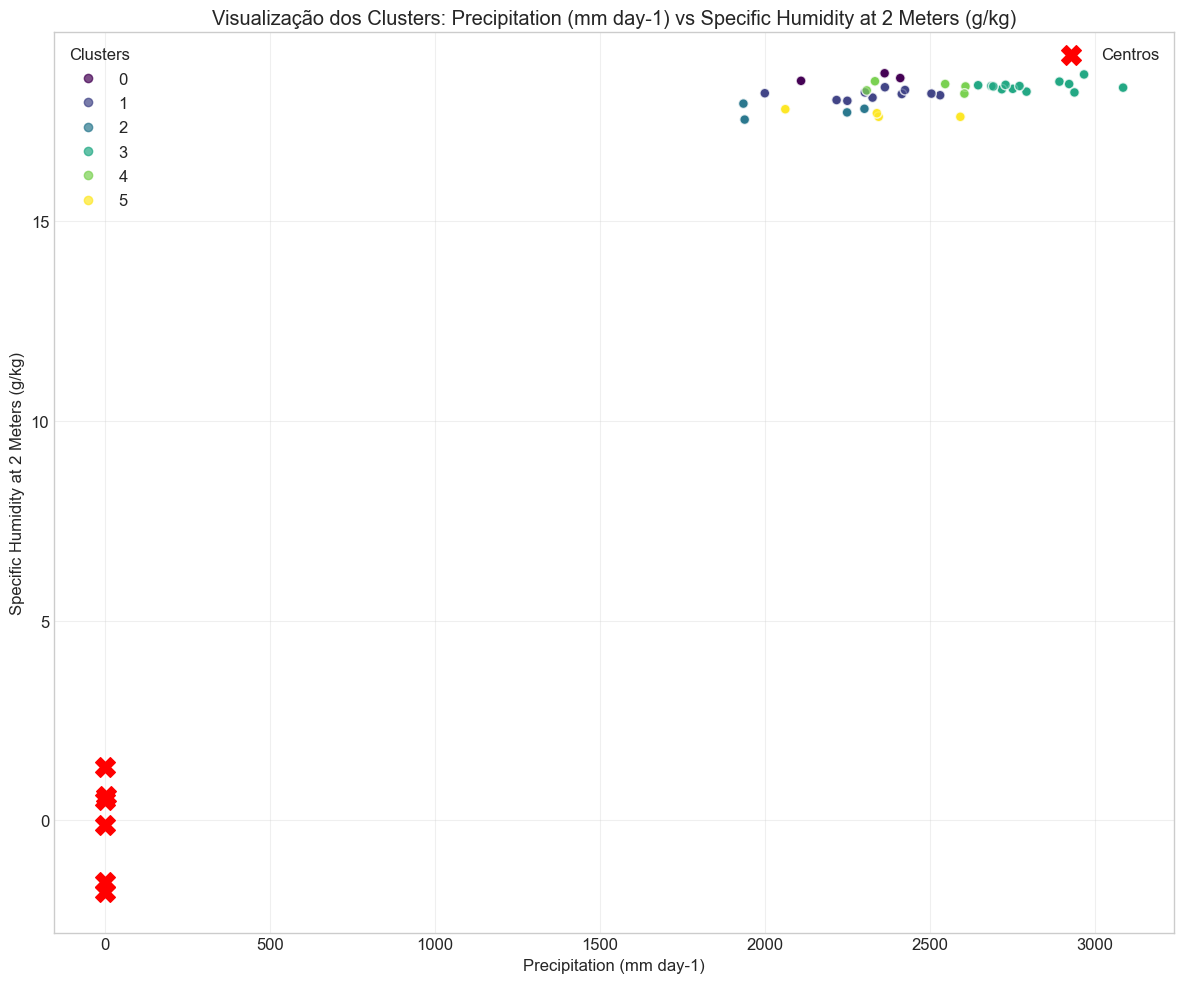

In [13]:
visualize_clusters_2d(cluster_df, feature_names, centers_df)

### 4.5 Visualização dos Clusters em 3D

In [14]:
def visualize_clusters_3d(cluster_df, centers_df, scaled_features, feature_names):
    print("\n"+"="*50)
    print("VISUALIZAÇÃO DOS CLUSTERS EM 3D")
    print("="*50)
    if scaled_features.shape[1]<3:
        print("Não há features suficientes para 3D.")
        return

    f1,f2,f3=feature_names[0],feature_names[1],feature_names[2]
    fig=plt.figure(figsize=(12,10))
    ax=fig.add_subplot(111, projection='3d')
    scatter=ax.scatter(cluster_df[f1],cluster_df[f2],cluster_df[f3],
                       c=cluster_df['Cluster'], cmap='viridis', s=50, alpha=0.7)
    if {f1,f2,f3}.issubset(centers_df.columns):
        cvals=centers_df[[f1,f2,f3]].values
        ax.scatter(cvals[:,0], cvals[:,1], cvals[:,2],
                   c='red', marker='X', s=200, alpha=1,
                   label='Centros')
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_zlabel(f3)
    ax.set_title('Visualização 3D dos Clusters')
    legend1=ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.legend(["Centros"], loc="upper right")
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR,'clusters_3d.png'))
    plt.show()


VISUALIZAÇÃO DOS CLUSTERS EM 3D


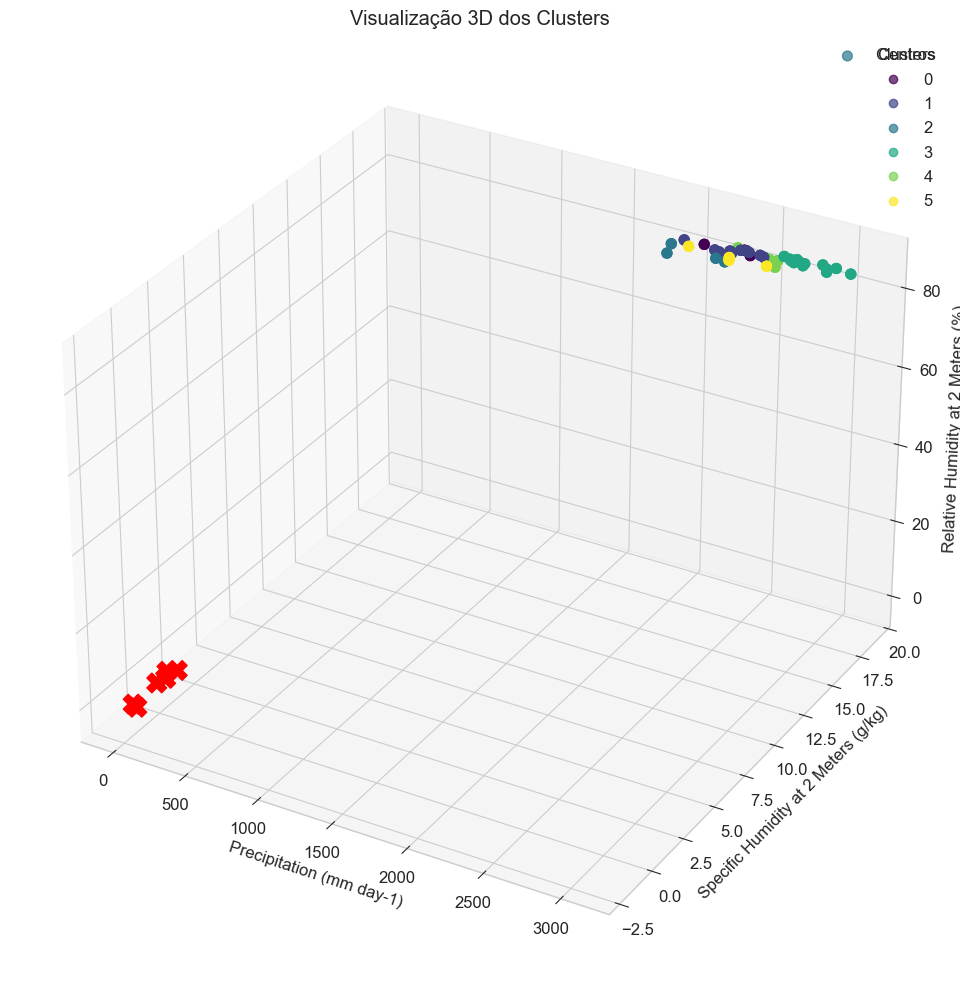

In [15]:
visualize_clusters_3d(cluster_df, centers_df, scaled_features, feature_names)

### 4.6 Identificação de Outliers dentro dos Clusters


IDENTIFICANDO OUTLIERS DENTRO DOS CLUSTERS
Total de outliers: 12 (7.7%)

Outliers por cluster:
Cluster 0: 0 outliers (0.0%)
Cluster 1: 0 outliers (0.0%)
Cluster 2: 0 outliers (0.0%)
Cluster 3: 4 outliers (7.7%)
Cluster 4: 4 outliers (20.0%)
Cluster 5: 4 outliers (25.0%)


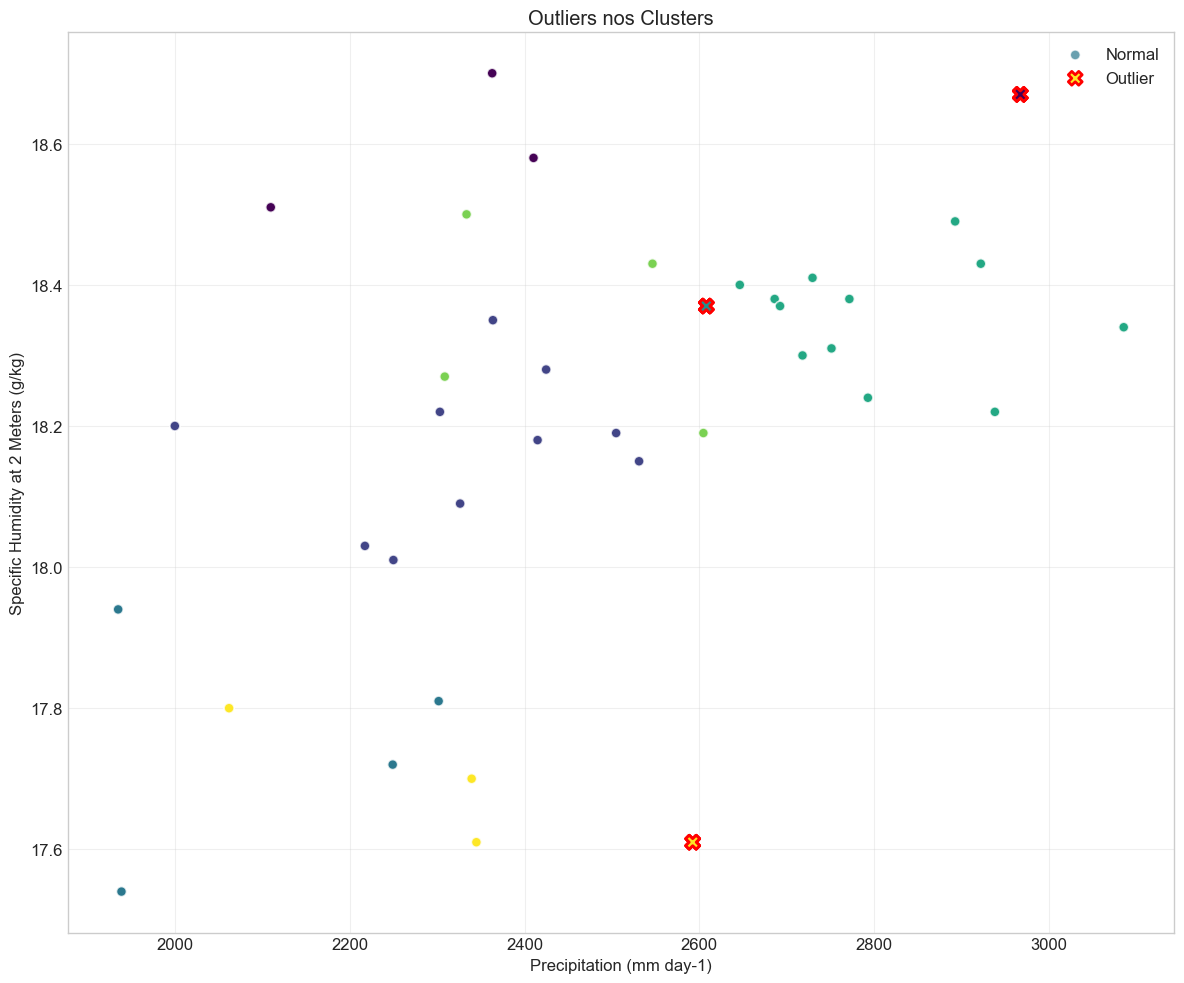

Visualização de outliers salva em '..\images\cluster_outliers.png'

Características dos outliers:
Precipitation (mm day-1): Média outliers=2722.57, normal=2466.83, dif=255.75
Specific Humidity at 2 Meters (g/kg): Média outliers=18.22, normal=18.20, dif=0.01
Relative Humidity at 2 Meters (%): Média outliers=85.07, normal=84.71, dif=0.36
Temperature at 2 Meters (C): Média outliers=26.12, normal=26.19, dif=-0.07


In [16]:
def identify_cluster_outliers(cluster_df, feature_names):
    print("\n"+"="*50)
    print("IDENTIFICANDO OUTLIERS DENTRO DOS CLUSTERS")
    print("="*50)

    outlier_df=cluster_df.copy()
    outlier_df['is_outlier']=False
    for cl in sorted(outlier_df['Cluster'].unique()):
        cdata=outlier_df[outlier_df['Cluster']==cl]
        for ft in feature_names:
            Q1=cdata[ft].quantile(0.25)
            Q3=cdata[ft].quantile(0.75)
            IQR=Q3-Q1
            lb=Q1-1.5*IQR
            ub=Q3+1.5*IQR
            is_out=(cdata[ft]<lb)|(cdata[ft]>ub)
            outlier_df.loc[is_out.index, 'is_outlier'] = is_out

    out_count=outlier_df['is_outlier'].sum()
    print(f"Total de outliers: {out_count} ({out_count/len(outlier_df)*100:.1f}%)")

    print("\nOutliers por cluster:")
    for cl in sorted(outlier_df['Cluster'].unique()):
        cdata=outlier_df[outlier_df['Cluster']==cl]
        ccount=cdata['is_outlier'].sum()
        print(f"Cluster {cl}: {ccount} outliers ({ccount/len(cdata)*100:.1f}%)")

    if len(feature_names)>=2:
        plt.figure(figsize=(12,10))
        non_out=outlier_df[~outlier_df['is_outlier']]
        outs=outlier_df[outlier_df['is_outlier']]
        plt.scatter(non_out[feature_names[0]], non_out[feature_names[1]],
                    c=non_out['Cluster'], cmap='viridis', s=50,
                    alpha=0.7, edgecolors='w', label='Normal')
        plt.scatter(outs[feature_names[0]], outs[feature_names[1]],
                    c=outs['Cluster'], cmap='viridis', s=100,
                    alpha=1.0, edgecolors='red', linewidth=2,
                    marker='X', label='Outlier')
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
        plt.title('Outliers nos Clusters')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_DIR,'cluster_outliers.png'))
        plt.show()
        print(f"Visualização de outliers salva em '{os.path.join(IMAGES_DIR,'cluster_outliers.png')}'")

    if out_count>0:
        print("\nCaracterísticas dos outliers:")
        outs=outlier_df[outlier_df['is_outlier']]
        nono=outlier_df[~outlier_df['is_outlier']]
        for ft in feature_names:
            outm=outs[ft].mean()
            nonm=nono[ft].mean()
            print(f"{ft}: Média outliers={outm:.2f}, normal={nonm:.2f}, dif={outm-nonm:.2f}")

    return outlier_df

outlier_df = identify_cluster_outliers(cluster_df, feature_names)

### 4.7 Resumo dos Resultados do Clustering

In [17]:
def summarize_clustering_results(cluster_df, centers_df, feature_names, outlier_df=None):
    print("\n"+"="*50)
    print("RESUMO DOS RESULTADOS DO CLUSTERING")
    print("="*50)
    n_clusters=len(centers_df)
    print(f"Número de clusters: {n_clusters}")
    print(f"Número de amostras: {len(cluster_df)}")
    print(f"Features utilizadas: {', '.join(feature_names)}")

    print("\nDistribuição de amostras por cluster:")
    ccounts=cluster_df['Cluster'].value_counts().sort_index()
    plt.figure(figsize=(10,6))
    bars=plt.bar(ccounts.index, ccounts.values, color='skyblue')
    for bar in bars:
        h=bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2., h+0.1,
                 f'{h} ({(h/len(cluster_df))*100:.1f}%)',
                 ha='center', va='bottom')
    plt.xlabel('Cluster')
    plt.ylabel('Número de Amostras')
    plt.title('Distribuição de Amostras por Cluster')
    plt.xticks(ccounts.index)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR,'cluster_distribution.png'))
    plt.show()

    print("\nCaracterísticas de cada cluster (médias):")
    cluster_means=cluster_df.groupby('Cluster')[feature_names].mean()
    display(cluster_means)

    print("\nComparando características dos clusters (Radar Chart):")
    mscaler=MinMaxScaler()
    cluster_means_scaled=pd.DataFrame(mscaler.fit_transform(cluster_means),
                                      columns=cluster_means.columns,
                                      index=cluster_means.index)
    categories=feature_names
    N=len(categories)
    angles=[n/float(N)*2*np.pi for n in range(N)]
    angles+=angles[:1]
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(polar=True))
    for cl in cluster_means_scaled.index:
        vals=cluster_means_scaled.loc[cl].values.tolist()
        vals+=vals[:1]
        ax.plot(angles, vals, linewidth=2, linestyle='solid', label=f'Cluster {cl}')
        ax.fill(angles, vals, alpha=0.1)
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([0,0.25,0.5,0.75,1], ['0','0.25','0.5','0.75','1'], color='grey', size=7)
    plt.ylim(0,1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1,0.1))
    plt.title('Comparação de Características entre Clusters', size=15, y=1.1)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR,'cluster_radar_chart.png'))
    plt.show()

    print("\nInsights e Conclusões:")
    if 'yield' in feature_names:
        best_cluster=cluster_means['yield'].idxmax()
        print(f"- O Cluster {best_cluster} tem maior produtividade média.")
        print("  Características deste cluster:")
        for ft in feature_names:
            if ft!='yield':
                val=cluster_means.loc[best_cluster, ft]
                overall=cluster_df[ft].mean()
                diff=((val-overall)/overall)*100
                direction='maior' if diff>0 else 'menor'
                print(f"  - {ft}: {val:.2f} ({abs(diff):.1f}% {direction} que média geral)")

    if outlier_df is not None and 'is_outlier' in outlier_df.columns:
        print("\nRelação entre Clusters e Outliers:")
        outlier_by_cluster=outlier_df.groupby('Cluster')['is_outlier'].mean()*100
        for c,pct in outlier_by_cluster.items():
            print(f"  Cluster {c}: {pct:.1f}% de outliers")
        if len(outlier_by_cluster)>0:
            most_out = outlier_by_cluster.idxmax()
            print(f"- O Cluster {most_out} possui maior % de outliers: {outlier_by_cluster[most_out]:.1f}%")

    print("\nSugestões para Análise Adicional:")
    print("- Realizar análise de regressão para cada cluster.")
    print("- Investigar condições ambientais e práticas agrícolas.")
    print("- Aplicar ML supervisionado para prever produtividade.")
    print("- Criar recomendações personalizadas para cada grupo.")



RESUMO DOS RESULTADOS DO CLUSTERING
Número de clusters: 6
Número de amostras: 156
Features utilizadas: Precipitation (mm day-1), Specific Humidity at 2 Meters (g/kg), Relative Humidity at 2 Meters (%), Temperature at 2 Meters (C)

Distribuição de amostras por cluster:


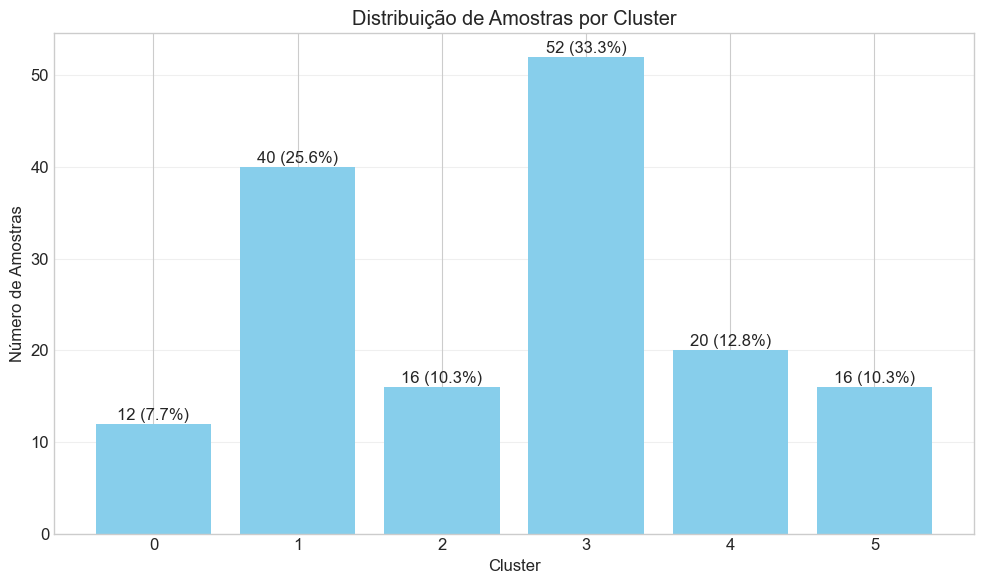


Características de cada cluster (médias):


,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C)
Cluster,,,,
0,2294.090000,18.596667,83.666667,26.773333
1,2333.406000,18.170000,84.872000,26.127000
2,2105.875000,17.752500,82.932500,26.142500
3,2814.984615,18.380000,85.722308,26.143846
4,2480.170000,18.352000,84.168000,26.434000
5,2334.495000,17.680000,84.522500,25.740000



Comparando características dos clusters (Radar Chart):


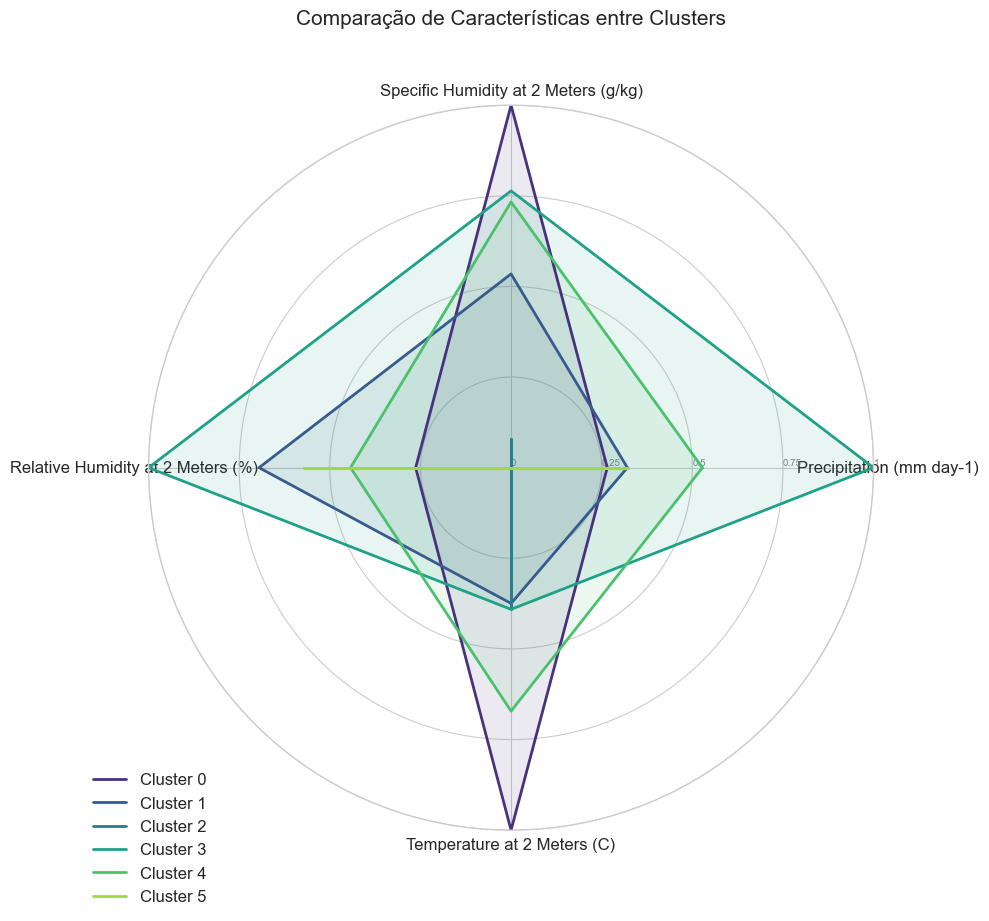


Insights e Conclusões:

Relação entre Clusters e Outliers:
  Cluster 0: 0.0% de outliers
  Cluster 1: 0.0% de outliers
  Cluster 2: 0.0% de outliers
  Cluster 3: 7.7% de outliers
  Cluster 4: 20.0% de outliers
  Cluster 5: 25.0% de outliers
- O Cluster 5 possui maior % de outliers: 25.0%

Sugestões para Análise Adicional:
- Realizar análise de regressão para cada cluster.
- Investigar condições ambientais e práticas agrícolas.
- Aplicar ML supervisionado para prever produtividade.
- Criar recomendações personalizadas para cada grupo.


In [18]:
summarize_clustering_results(cluster_df, centers_df, feature_names, outlier_df)

## 5. Conclusões da Análise de Clustering

Nesta análise, aplicamos o algoritmo K-Means para identificar padrões naturais nos dados de produtividade agrícola. Através da análise de clustering, conseguimos identificar grupos distintos de produtores/regiões com características semelhantes.

### Principais Descobertas:

1. **Identificação de Grupos Distintos**
2. **Relação entre Variáveis e Produtividade**
3. **Identificação de Outliers**

### Implicações Práticas:

- **Recomendações Personalizadas**
- **Otimização de Recursos**
- **Previsão de Produtividade**

### Próximos Passos:

Na próxima etapa, iremos desenvolver modelos de aprendizado supervisionado para prever a produtividade com base nessas variáveis.

## 6. Modelagem Preditiva (Aprendizado Supervisionado)

Nesta seção, vamos **transformar** colunas categóricas (ex: `'Crop'`) em numéricas via One-Hot, para que não haja erro de “could not convert string to float” nos modelos.

Renomeei a coluna 'Yield' para 'yield'.
Index(['Crop', 'Precipitation (mm day-1)',
       'Specific Humidity at 2 Meters (g/kg)',
       'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)',
       'yield'],
      dtype='object')

PREPARAÇÃO DOS DADOS PARA MODELAGEM PREDITIVA
N amostras: 156
Colunas numéricas: ['Precipitation (mm day-1)', 'Specific Humidity at 2 Meters (g/kg)', 'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)']
Colunas categóricas: ['Crop']
Tamanho treino: 124 | Tamanho teste: 32


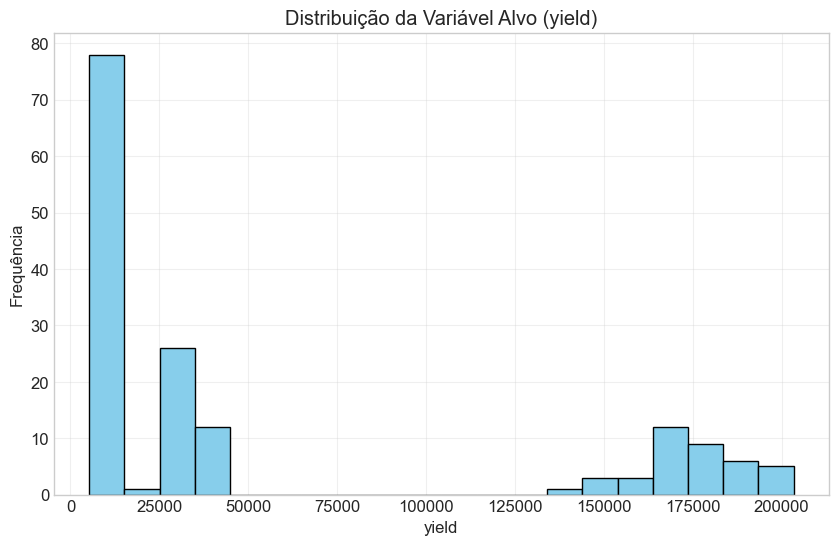

Transformações concluídas.
X_train shape após One-Hot + Scaling: (124, 7)
X_test shape : (32, 7)


In [19]:
def prepare_data_for_modeling(df, target_column='yield', test_size=0.2, random_state=42):
    """
    Prepara os dados para modelagem preditiva, separando features (X) e target (y),
    lidando com colunas categóricas via OneHotEncoder, e dividindo em treino e teste.
    Retorna X_train_processed, X_test_processed, y_train, y_test,
    preprocessor (caso queira analisar nomes de colunas geradas),
    numeric_cols, cat_cols.
    """
    #Se achar 'Yield', renomeie para 'yield'
    if 'Yield' in df.columns and 'yield' not in df.columns:
        df = df.rename(columns={'Yield': 'yield'})
        print("Renomeei a coluna 'Yield' para 'yield'.")
        
    print(df.columns)
    print("\n"+"="*50)
    print("PREPARAÇÃO DOS DADOS PARA MODELAGEM PREDITIVA")
    print("="*50)

    if target_column not in df.columns:
        raise ValueError(f"A coluna alvo '{target_column}' não foi encontrada no DataFrame.")

    # Se existirem colunas 'Cluster' e 'is_outlier', remover (não são features)
    cols_to_drop=[]
    if 'Cluster' in df.columns:
        cols_to_drop.append('Cluster')
    if 'is_outlier' in df.columns:
        cols_to_drop.append('is_outlier')

    X = df.drop([target_column]+cols_to_drop, axis=1)
    y = df[target_column]

    print(f"N amostras: {len(df)}")
    numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols    = X.select_dtypes(include=['object']).columns.tolist()
    print(f"Colunas numéricas: {numeric_cols}")
    print(f"Colunas categóricas: {cat_cols}")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    print(f"Tamanho treino: {len(X_train)} | Tamanho teste: {len(X_test)}")

    # Pipelines
    num_pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])
    cat_pipeline = Pipeline([
        ("onehot", OneHotEncoder(drop='first'))
    ])

    preprocessor = ColumnTransformer([
        ("num", num_pipeline, numeric_cols),
        ("cat", cat_pipeline, cat_cols)
    ])

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed  = preprocessor.transform(X_test)

    # Plot da distribuição do target
    plt.figure(figsize=(10,6))
    plt.hist(y, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribuição da Variável Alvo ({target_column})')
    plt.xlabel(target_column)
    plt.ylabel('Frequência')
    plt.grid(alpha=0.3)
    plt.savefig(os.path.join(IMAGES_DIR, 'target_distribution.png'))
    plt.show()

    print("Transformações concluídas.")
    print(f"X_train shape após One-Hot + Scaling: {X_train_processed.shape}")
    print(f"X_test shape : {X_test_processed.shape}")

    return (X_train_processed, X_test_processed, y_train, y_test,
            preprocessor, numeric_cols, cat_cols)

# Chamar a função
(X_train_proc, X_test_proc, y_train, y_test,
 preprocessor, numeric_cols, cat_cols) = prepare_data_for_modeling(
    df_clean, target_column='yield', test_size=0.2, random_state=42
)

### 6.2 Funções de Avaliação de Modelos

In [20]:
def evaluate_regression_model(model, X_train, X_test, y_train, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    train_r2  = r2_score(y_train, y_train_pred)
    test_r2   = r2_score(y_test,  y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae  = mean_absolute_error(y_test,  y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse  = mean_squared_error(y_test,  y_test_pred)
    train_rmse= np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    print(f"\n--- {model_name} ---")
    print(f"Treino -> R²={train_r2:.4f}, MAE={train_mae:.4f}, MSE={train_mse:.4f}, RMSE={train_rmse:.4f}")
    print(f"Teste  -> R²={test_r2:.4f},  MAE={test_mae:.4f},  MSE={test_mse:.4f},  RMSE={test_rmse:.4f}")

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_test_pred, alpha=0.7)
    min_v=min(min(y_test), min(y_test_pred))
    max_v=max(max(y_test), max(y_test_pred))
    plt.plot([min_v,max_v],[min_v,max_v],'r--')
    plt.xlabel("Valores Reais")
    plt.ylabel("Valores Preditos")
    plt.title(f"{model_name} (Teste)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR, f"{model_name.lower().replace(' ','_')}_predictions.png"))
    plt.show()

    metrics={
        'model_name': model_name,
        'train_r2': train_r2,
        'test_r2':  test_r2,
        'train_mae': train_mae,
        'test_mae':  test_mae,
        'train_mse': train_mse,
        'test_mse':  test_mse,
        'train_rmse':train_rmse,
        'test_rmse': test_rmse
    }
    return metrics

def plot_feature_importance(model, model_name, preprocessor, numeric_cols, cat_cols):
    """
    Tenta plotar a importância das features.
    Observando que, após OneHot, o número de colunas aumenta.
    """
    # Extrair nome das colunas pós-OneHot
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_encoded_cols = ohe.get_feature_names_out(cat_cols)
    all_features = list(numeric_cols) + list(cat_encoded_cols)

    if hasattr(model,'feature_importances_'):
        importances=model.feature_importances_
    elif hasattr(model,'coef_'):
        importances=np.abs(model.coef_)
    else:
        print(f"O modelo {model_name} não suporta feature_importances_ ou coef_.")
        return None

    if len(importances)!=len(all_features):
        print("Aviso: tamanho de importances difere do # de colunas.")
        return None

    imp_df=pd.DataFrame({'Feature':all_features, 'Importance':importances})
    imp_df=imp_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=imp_df)
    plt.title(f'Importância das Features - {model_name}')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR,f"feature_importance_{model_name.lower().replace(' ','_')}.png"))
    plt.show()
    display(imp_df)
    return imp_df

### 6.3 Implementação e Avaliação dos Modelos

#### 6.3.1 Regressão Linear


--- Regressão Linear ---
Treino -> R²=0.9872, MAE=5200.1187, MSE=66442009.9750, RMSE=8151.1968
Teste  -> R²=0.9950,  MAE=3132.7964,  MSE=19308693.2448,  RMSE=4394.1658


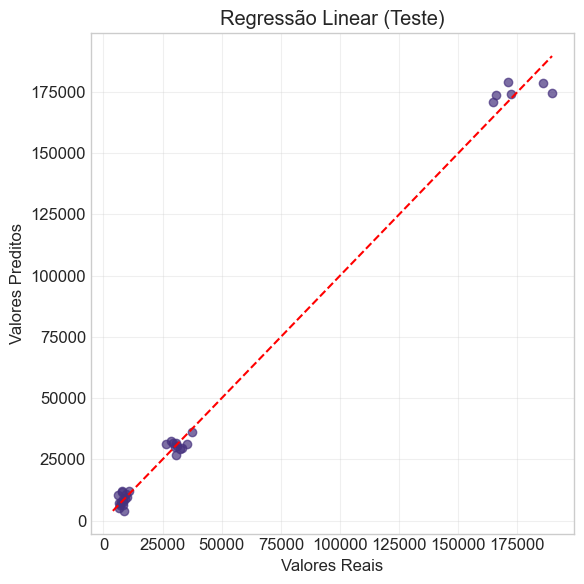

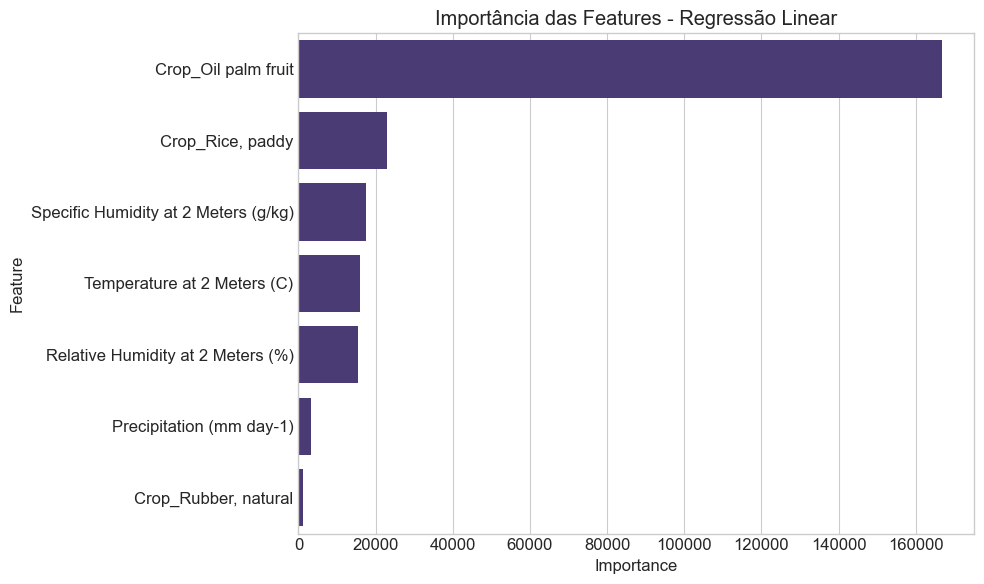

,Feature,Importance
0,Crop_Oil palm fruit,166783.334038
1,"Crop_Rice, paddy",22929.910209
2,Specific Humidity at 2 Meters (g/kg),17463.636440
3,Temperature at 2 Meters (C),16084.023004
4,Relative Humidity at 2 Meters (%),15379.273097
5,Precipitation (mm day-1),3248.568218
6,"Crop_Rubber, natural",1236.485773


In [21]:
# Regressão Linear
lr_model=LinearRegression()
lr_model.fit(X_train_proc, y_train)
lr_metrics=evaluate_regression_model(lr_model, X_train_proc, X_test_proc, y_train, y_test,
                                     "Regressão Linear")
lr_importance=plot_feature_importance(lr_model, "Regressão Linear",
                                     preprocessor,
                                     numeric_cols, cat_cols)


#### 6.3.2 Árvore de Decisão


--- Árvore de Decisão ---
Treino -> R²=1.0000, MAE=0.0000, MSE=0.0000, RMSE=0.0000
Teste  -> R²=0.9927,  MAE=3142.5312,  MSE=28263542.7188,  RMSE=5316.3467


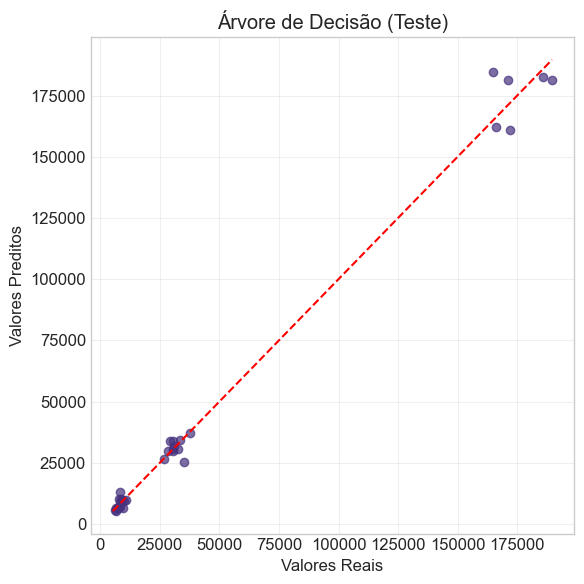

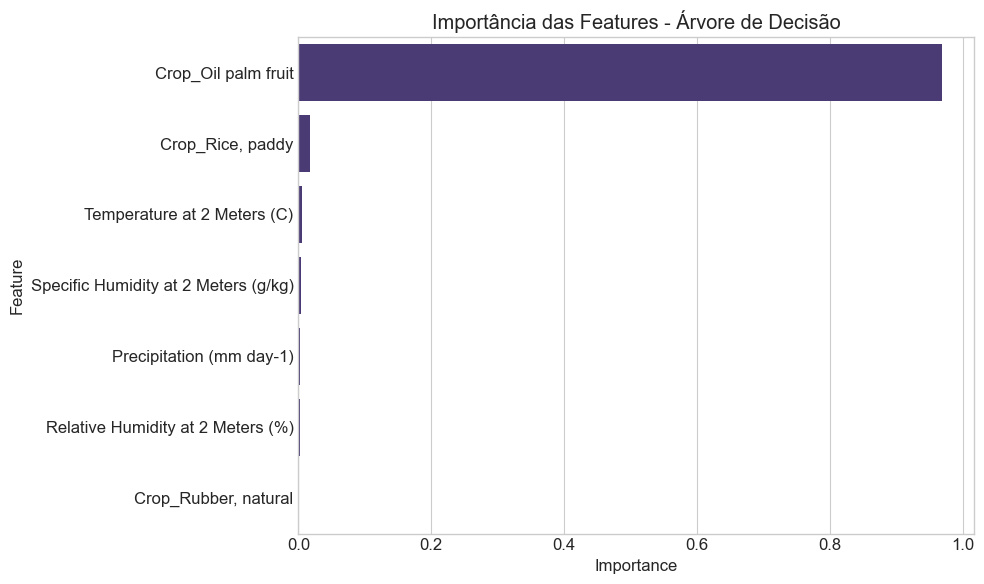

,Feature,Importance
0,Crop_Oil palm fruit,0.968775
1,"Crop_Rice, paddy",0.017358
2,Temperature at 2 Meters (C),0.004942
3,Specific Humidity at 2 Meters (g/kg),0.004121
4,Precipitation (mm day-1),0.002439
5,Relative Humidity at 2 Meters (%),0.002324
6,"Crop_Rubber, natural",0.000041


In [22]:
dt_model=DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_proc, y_train)
dt_metrics=evaluate_regression_model(dt_model, X_train_proc, X_test_proc, y_train, y_test,
                                     "Árvore de Decisão")
dt_importance=plot_feature_importance(dt_model, "Árvore de Decisão",
                                     preprocessor,
                                     numeric_cols, cat_cols)


#### 6.3.3 Random Forest


--- Random Forest ---
Treino -> R²=0.9982, MAE=1624.6588, MSE=9171038.7383, RMSE=3028.3723
Teste  -> R²=0.9939,  MAE=2797.3453,  MSE=23797857.0312,  RMSE=4878.3047


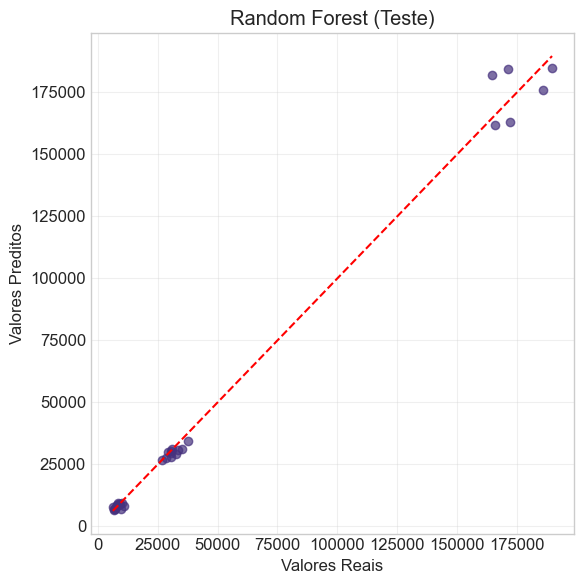

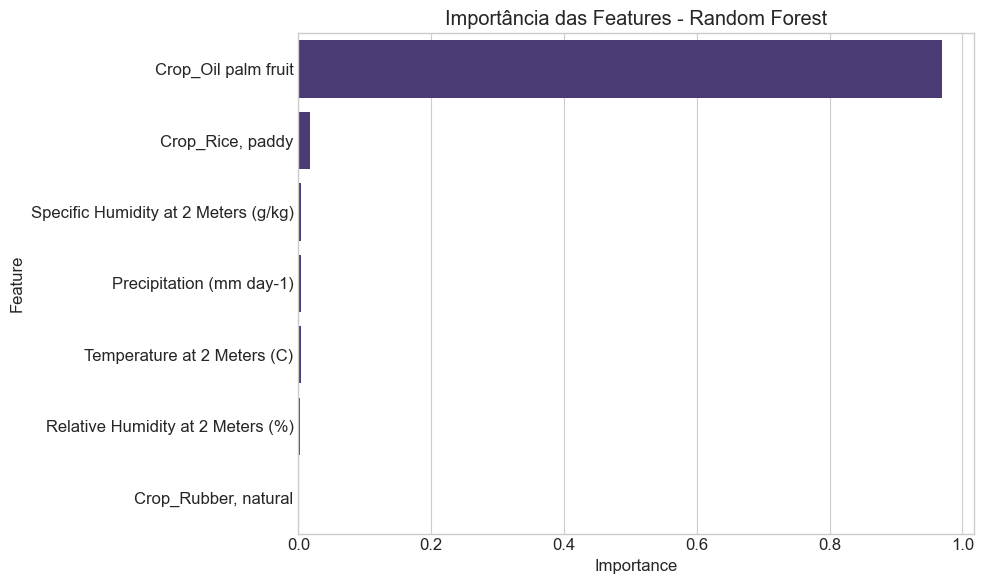

,Feature,Importance
0,Crop_Oil palm fruit,0.969180
1,"Crop_Rice, paddy",0.017492
2,Specific Humidity at 2 Meters (g/kg),0.004380
3,Precipitation (mm day-1),0.003536
4,Temperature at 2 Meters (C),0.003526
5,Relative Humidity at 2 Meters (%),0.001837
6,"Crop_Rubber, natural",0.000050


In [23]:
rf_model=RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_proc, y_train)
rf_metrics=evaluate_regression_model(rf_model, X_train_proc, X_test_proc, y_train, y_test,
                                     "Random Forest")
rf_importance=plot_feature_importance(rf_model, "Random Forest",
                                     preprocessor,
                                     numeric_cols, cat_cols)


#### 6.3.4 XGBoost


--- XGBoost ---
Treino -> R²=1.0000, MAE=272.6598, MSE=146020.3125, RMSE=382.1260
Teste  -> R²=0.9912,  MAE=3507.9033,  MSE=34063648.0000,  RMSE=5836.4071


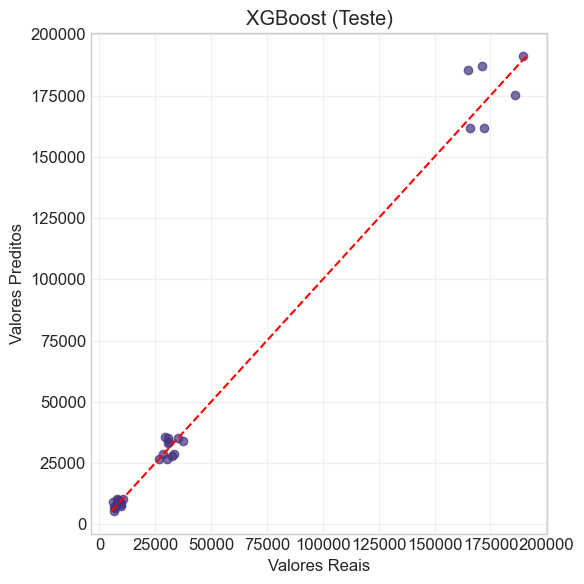

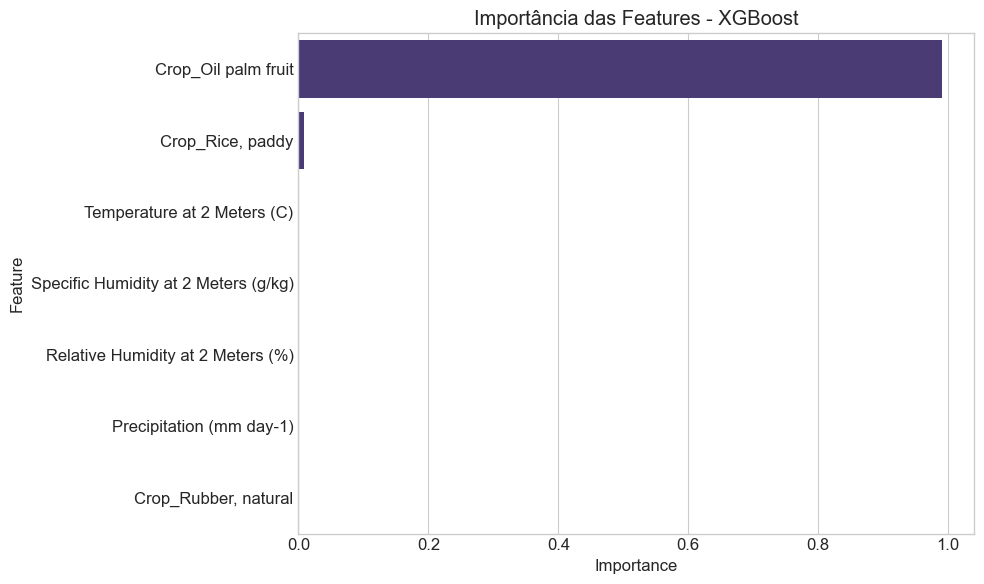

,Feature,Importance
0,Crop_Oil palm fruit,0.990158
1,"Crop_Rice, paddy",0.008006
2,Temperature at 2 Meters (C),0.000751
3,Specific Humidity at 2 Meters (g/kg),0.000417
4,Relative Humidity at 2 Meters (%),0.000318
5,Precipitation (mm day-1),0.000313
6,"Crop_Rubber, natural",0.000036


In [24]:
xgb_model=XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_proc, y_train)
xgb_metrics=evaluate_regression_model(xgb_model, X_train_proc, X_test_proc, y_train, y_test,
                                      "XGBoost")
xgb_importance=plot_feature_importance(xgb_model, "XGBoost",
                                      preprocessor,
                                      numeric_cols, cat_cols)


#### 6.3.5 Rede Neural (MLP Regressor)

d:\FIAP\Repositorios\farm-tech-solutions-v5\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



--- MLP Regressor ---
Treino -> R²=-0.0105, MAE=47077.7391, MSE=5227654857.4398, RMSE=72302.5232
Teste  -> R²=-0.0058,  MAE=36821.4368,  MSE=3901517795.7633,  RMSE=62462.1309


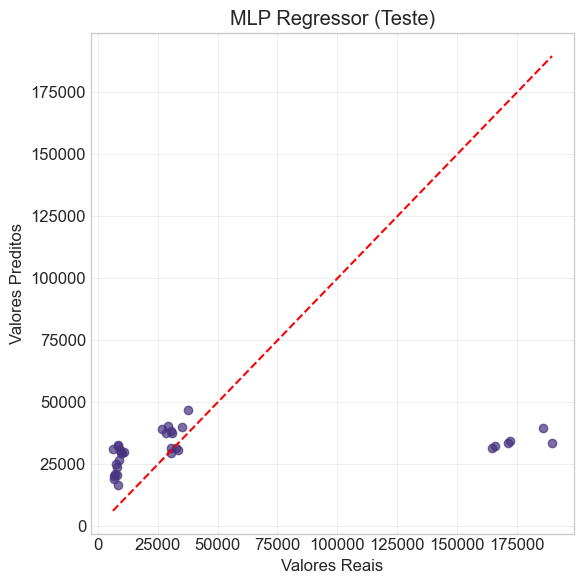


Nota: MLP Regressor não suporta feature_importances_ nem coef_ de modo trivial.


In [25]:
mlp_model=MLPRegressor(hidden_layer_sizes=(100,50), activation='relu',
                      max_iter=1000, random_state=42)
mlp_model.fit(X_train_proc, y_train)
mlp_metrics=evaluate_regression_model(mlp_model, X_train_proc, X_test_proc, y_train, y_test,
                                      "MLP Regressor")
print("\nNota: MLP Regressor não suporta feature_importances_ nem coef_ de modo trivial.")


### 6.4 Comparação dos Modelos


COMPARAÇÃO DOS MODELOS


,train_r2,test_r2,train_mae,test_mae,train_mse,test_mse,train_rmse,test_rmse
model_name,,,,,,,,
Regressão Linear,0.987157,0.995022,5200.118656,3132.796384,6.644201e+07,1.930869e+07,8151.196843,4394.165819
Árvore de Decisão,1.000000,0.992714,0.000000,3142.531250,0.000000e+00,2.826354e+07,0.000000,5316.346746
Random Forest,0.998227,0.993865,1624.658790,2797.345313,9.171039e+06,2.379786e+07,3028.372292,4878.304729
XGBoost,0.999972,0.991218,272.659821,3507.903320,1.460203e+05,3.406365e+07,382.126043,5836.407114
MLP Regressor,-0.010482,-0.005812,47077.739061,36821.436839,5.227655e+09,3.901518e+09,72302.523175,62462.130894



Melhor modelo (R² teste): Regressão Linear (R²=0.9950)
Melhor modelo (RMSE teste): Regressão Linear (RMSE=4394.1658)


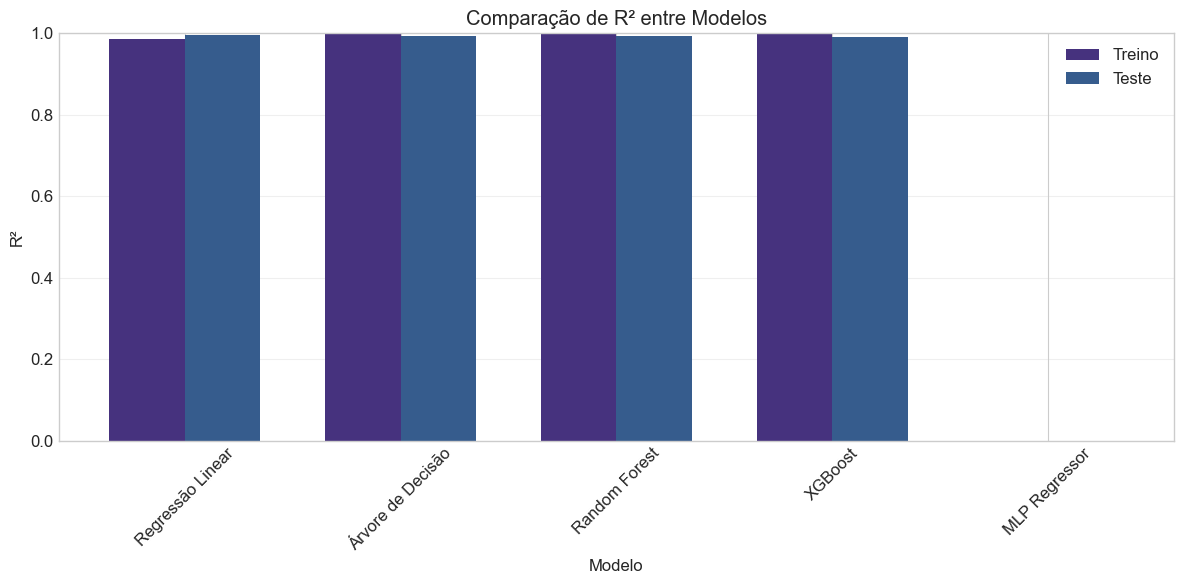

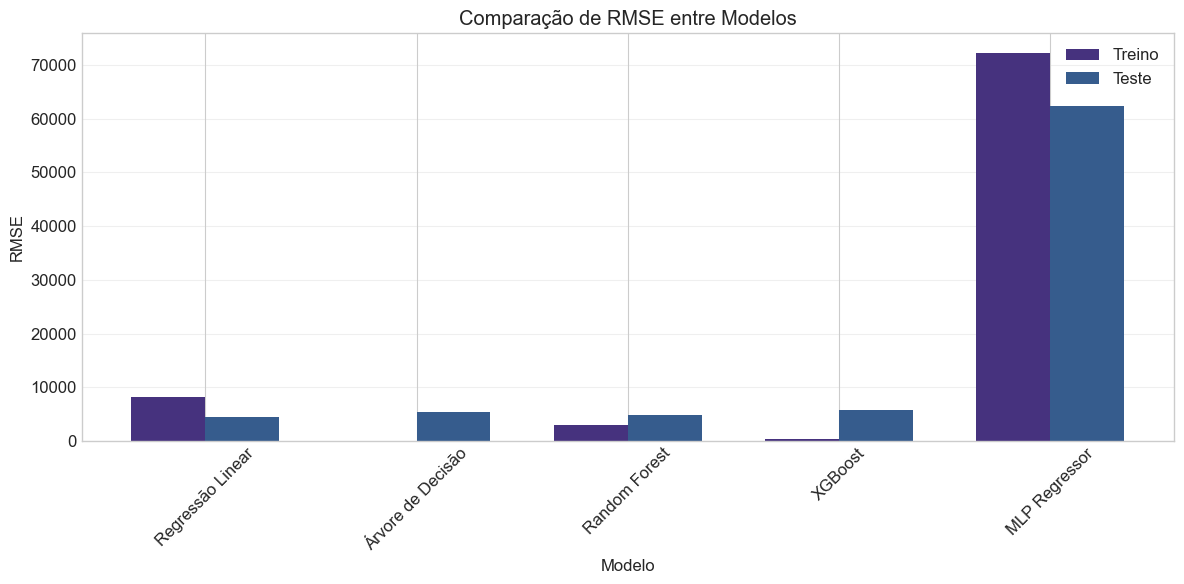


Verificação de Overfitting:
- Regressão Linear: Sem grande overfitting (dif.R²=-0.0079)
- Árvore de Decisão: Sem grande overfitting (dif.R²=0.0073)
- Random Forest: Sem grande overfitting (dif.R²=0.0044)
- XGBoost: Sem grande overfitting (dif.R²=0.0088)
- MLP Regressor: Sem grande overfitting (dif.R²=-0.0047)

CONCLUSÃO:
Melhor modelo (R² teste): Regressão Linear


In [26]:
def compare_models(metrics_list):
    print("\n"+"="*50)
    print("COMPARAÇÃO DOS MODELOS")
    print("="*50)
    df_comp = pd.DataFrame(metrics_list).set_index('model_name')
    display(df_comp)
    best_r2_model = df_comp['test_r2'].idxmax()
    best_r2_val   = df_comp.loc[best_r2_model,'test_r2']
    print(f"\nMelhor modelo (R² teste): {best_r2_model} (R²={best_r2_val:.4f})")
    best_rmse_model = df_comp['test_rmse'].idxmin()
    best_rmse_val   = df_comp.loc[best_rmse_model,'test_rmse']
    print(f"Melhor modelo (RMSE teste): {best_rmse_model} (RMSE={best_rmse_val:.4f})")

    # Comparar R²
    plt.figure(figsize=(12,6))
    model_names = df_comp.index
    train_r2 = df_comp['train_r2']
    test_r2  = df_comp['test_r2']
    x = np.arange(len(model_names))
    width=0.35
    plt.bar(x - width/2, train_r2, width, label='Treino')
    plt.bar(x + width/2, test_r2,  width, label='Teste')
    plt.xlabel('Modelo')
    plt.ylabel('R²')
    plt.title('Comparação de R² entre Modelos')
    plt.xticks(x, model_names, rotation=45)
    plt.ylim(0,1)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR,'model_r2_comparison.png'))
    plt.show()

    # Comparar RMSE
    plt.figure(figsize=(12,6))
    train_rmse = df_comp['train_rmse']
    test_rmse  = df_comp['test_rmse']
    plt.bar(x - width/2, train_rmse, width, label='Treino')
    plt.bar(x + width/2, test_rmse,  width, label='Teste')
    plt.xlabel('Modelo')
    plt.ylabel('RMSE')
    plt.title('Comparação de RMSE entre Modelos')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR,'model_rmse_comparison.png'))
    plt.show()

    print("\nVerificação de Overfitting:")
    for model in model_names:
        diff = df_comp.loc[model,'train_r2'] - df_comp.loc[model,'test_r2']
        if diff>0.1:
            print(f"- {model}: Possível overfitting (dif.R²={diff:.4f})")
        else:
            print(f"- {model}: Sem grande overfitting (dif.R²={diff:.4f})")

    print("\nCONCLUSÃO:")
    print(f"Melhor modelo (R² teste): {best_r2_model}")
    return df_comp

all_metrics=[lr_metrics, dt_metrics, rf_metrics, xgb_metrics, mlp_metrics]
model_comparison=compare_models(all_metrics)

## 7. Conclusões e Próximos Passos

### 7.1 Resumo dos Resultados
Conduzimos:
1. EDA e limpeza
2. Clusterização (K-Means)
3. Modelos de Regressão

### 7.2 Próximos Passos
- Otimização de hiperparâmetros
- Feature engineering
- Validação cruzada
- Explicabilidade de modelos (ex.: SHAP)
- Implementação prática (dashboard, APIs)
